## Imports

In [1]:
%autosave 120

Autosaving every 120 seconds


In [2]:
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

print("hi")
from transformer_lens.hook_points import HookPoint
print("tl")
import torch
from einops import rearrange
import torch
from tqdm.notebook import tqdm
from jaxtyping import Float
from dataclasses import dataclass, field
from copy import deepcopy
from typing import List, Dict, Callable, Union
from functools import partial
from IPython.display import display, clear_output
import ipywidgets
import pathlib
import cloudpickle
from collections import defaultdict
from functools import partial
print("other")
torch.set_grad_enabled(False)

# from transformer lens
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Parse the PyTorch version to check if it's below version 2.0
        major_version = int(torch.__version__.split(".")[0])
        if major_version >= 2:
            return torch.device("mps")

    return torch.device("cpu")
device = get_device()
print("device", device)

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if fix_size:
        # default settings aren't very good, these are better
        plot_args = {
            'width': 800,
            'height': 600,
            "autosize": False,
            'showlegend': True,
            'margin': {"l":0,"r":0,"t":100,"b":0}
        }
        if model.cfg.n_layers < len(kwargs['y']):
            plot_args['height'] *= model.cfg.D_conv
        
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
    if show:
        fig.show(renderer)
    else:
        return fig

def show(data, x, xaxis, yaxis, title, clipped):
    if clipped:
        imshow(data[:,2:], x=x[2:], xaxis=xaxis, yaxis=yaxis, title=title)
    else:
        imshow(data, x=x, xaxis=xaxis, yaxis=yaxis, title=title)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()


hi
tl
other
device cuda


## Load Model

In [4]:
from mamba_lens import HookedMamba
from transformers.utils.hub import cached_file
from transformers.utils import WEIGHTS_NAME, CONFIG_NAME
import os
print(torch.cuda.is_available())
model_path = "state-spaces/mamba-370m"
print("model cached at", cached_file(model_path, WEIGHTS_NAME))
model = HookedMamba.from_pretrained(model_path, device='cuda')
from transformer_lens import HookedTransformer
#model = HookedTransformer.from_pretrained("gpt2-small")
torch.set_grad_enabled(False)

True
model cached at /home/dev/.cache/huggingface/hub/models--state-spaces--mamba-370m/snapshots/b6c47221dc4908532cc9773d469d6b8cbe3f0762/pytorch_model.bin


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Utility Functions

In [5]:
def cosine_similarity(vec1, vec2):
    vec1 = torch.tensor(vec1)
    vec2 = torch.tensor(vec2)
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return sims

def hook_was_added_by_hookpoint(hook):
    return "HookPoint." in str(repr(hook))
        

def clean_hooks(model):
    model.remove_all_hook_fns(including_permanent=True, level=None)
    model.reset_hooks(including_permanent=True, level=None)
    # extra stuff in case that wasn't everything
    # this can happen if you interrupt between the time the hook is added to python
    # but before python has a chance to add the handle to the list HookPoint holds onto
    for name, module in model.named_modules():
        for k, v in list(module._forward_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._forward_hooks[k]
            
        for k, v in list(module._forward_pre_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._forward_pre_hooks[k]
            
        for k, v in list(module._backward_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._backward_hooks[k]


def get_pad_token(tokenizer):
    return tokenizer.pad_token_id

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)

def eval_debug(model, data, correct, incorrect, constrain_to_answers, tags, batch_size, top_k=2, patch=False, print_all=False, **kwargs):
    num_correct = 0
    num_incorrect = 0
    num_correct_tags = defaultdict(lambda: 0)
    num_incorrect_tags = defaultdict(lambda: 0)
    for batch_start in tqdm(list(range(0, correct.size()[0], batch_size))):
        batch_end = min(batch_start+batch_size, correct.size()[0])
        inputs = data[batch_start:batch_end]
        batch_logits = model(inputs, **kwargs)[:,-1]
        for b in range(batch_start, batch_end):
            if patch and b % 2 != 0: continue # ignore every other when patching
            logits = batch_logits[b-batch_start]
            input = model.tokenizer.decode(data[b])
            correct_answers = correct[b]
            incorrect_answers = incorrect[b]
            if constrain_to_answers:
                only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
                only_consider_answer_logits[correct_answers] = logits[correct_answers]
                only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
                logits = only_consider_answer_logits
            prs = torch.nn.functional.softmax(logits, dim=0)
            top = torch.argsort(-logits)[:top_k]
            printed = False
            printed_prompt = False
            for i, tok in enumerate(top):
                if not i == 0 and tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  correct top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                    #print("correct")
                    #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
                elif i == 0 and not tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  incorrect top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                if tok in correct_answers:
                    if i == 0:
                        num_correct += 1
                        if not tags is None:
                            num_correct_tags[tags[b]] += 1
                        if print_all:
                            if not printed_prompt:
                                if not tags is None:
                                    print(tags[b])
                                print("prompt", input)
                                printed_prompt = True
                            print(f"  correct top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    break
                else:
                    if i == 0:
                        num_incorrect += 1
                        if not tags is None:
                            num_incorrect_tags[tags[b]] += 1
            
            if printed:
                print()
    return num_correct, num_incorrect, num_correct_tags, num_incorrect_tags

def eval(model, data, correct, incorrect, constrain_to_answers, batch_size=200, patch=False, **kwargs):
        if patch and batch_size % 2 != 0:
            raise ValueError(f"when patch=True, batch size ({batch_size}) must be a multiple of two (because every other input is patch input)")
        num_examples = correct.size()[0]
        total_num_correct = 0
        correct_prs_all = []
        incorrect_prs_all = []
        total_n_data = 0
        for batch_start in list(range(0, correct.size()[0], batch_size)):
            batch_end = min(batch_start+batch_size, correct.size()[0])
            batch_inputs = data[batch_start:batch_end]
            batch_correct = correct[batch_start:batch_end]
            batch_incorrect = incorrect[batch_start:batch_end]
            cur_batch_size = batch_inputs.size()[0]
            if patch:
                batch_correct = batch_correct[::2]
                batch_incorrect = batch_incorrect[::2]
            logits = model(batch_inputs, **kwargs)[:,-1]
            if patch:
                logits = logits[::2]
            pad = get_pad_token(tokenizer=model.tokenizer)
            logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
            
            n_data, n_correct = batch_correct.size()
            n_data, n_incorrect = batch_incorrect.size()

            total_n_data += n_data
    
            if constrain_to_answers:
                # [n_data, n_correct]
                correct_logits = index_into(logits, batch_correct)
                # [n_data, n_incorrect]
                incorrect_logits = index_into(logits, batch_incorrect)
                # [n_data, n_correct + n_incorrect]
                combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
                combined_prs = torch.softmax(combined_logits, dim=1)
                biggest = torch.argsort(-combined_prs, dim=1)
                # if biggest pr is in the correct, we are correct, otherwise, we are not
                num_correct = torch.sum(biggest[:,0] < n_correct)
        
                correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            else:
                prs = torch.nn.functional.softmax(logits, dim=1)
                # [n_data, n_correct]
                correct_prs = index_into(prs, batch_correct)
                # [n_data, n_incorrect]
                incorrect_prs = index_into(prs, batch_incorrect)
                # [n_data, 1]
                top_tokens = torch.topk(logits, 1, dim=1).indices
                # [n_data, n_correct]
                is_correct = top_tokens == batch_correct
                # [n_data]
                has_any_correct = torch.any(is_correct, dim=1)
                # [1]
                num_correct = torch.sum(has_any_correct)
            correct_prs_all.append(correct_prs)
            incorrect_prs_all.append(incorrect_prs)
            total_num_correct += num_correct.item()
        incorrect_prs_all = torch.cat(incorrect_prs_all, dim=0)
        correct_prs_all = torch.cat(correct_prs_all, dim=0)
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs_all.sum(dim=1)).item(), torch.mean(incorrect_prs_all.sum(dim=1)).item(), total_num_correct/float(total_n_data)


def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []

    bos = [model.tokenizer.bos_token_id]
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 7:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(bos + model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

# because every pair (i,i+1) is a patching (uncorrupted, corrupted),
# we want things to be symmetric,
# so we will double up our dataset
# by swapping each pair
def repeat_swapped_patch(vec, has_symmetric_patching=False):
    if not has_symmetric_patching: # don't do this if we don't have symmetric patching
        return vec
    else:
        swapped_vecs = []
        for i in range(0, vec.size()[0], 2):
            swapped_vecs += [vec[i+1:i+2], vec[i:i+1]]
        return torch.cat([vec] + swapped_vecs, dim=0)


def wrap_run_with_hooks(model, fwd_hooks, bwd_hooks=[], **kwargs):
    def wrapper(input, fwd_hooks, bwd_hooks):
        return model.run_with_hooks(input, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks, **kwargs)
    wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks)
    wrapper_with_hooks.tokenizer = model.tokenizer
    wrapper_with_hooks.cfg = model.cfg
    return wrapper_with_hooks

## Generate Data

In [6]:
# todo: accuracy diff or pr diff instead of logit diff

from docstring import docstring_prompt_generator_function
from importlib import reload
import random
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator, IOI_custom_generator
test_data.good_names = None

num_examples = 100

seed = 29
valid_seed = 38
test_seed = 48

batch_size = 500

# todo: move name tokens further apart so they can't use conv
data_type = 'ioi custom'

constrain_to_answers = True
# for most tasks, we can do symmetric patching, where if we patch A->B we also patch B->A for every pair
# however for some tasks like greater than this doesn't make sense, so we have this option
has_symmetric_patching = True 

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'ioi custom':
    ioi_format = """
ABC AB C
ABC AC B""".strip()
    all_formats = list(test_data.extra_pruned_abc()) # this is all the one variable patchings
    #all_formats = [ioi_format] # use this if u just want your specific format
    for f in all_formats:
        print(f)
    if len(all_formats) > 1:
        print("WARNING: Using multiple formats")
    data, valid_data, test_data = [], [], []
    random.seed(seed)
    base_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(valid_seed)
    valid_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(test_seed)
    test_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    for this_seed, this_valid_seed, this_test_seed, abc_format in zip(base_seeds, valid_seeds, test_seeds, all_formats):
        data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_seed))
        print(data[-2])
        print(data[-1])
        print()
        valid_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_valid_seed))
        test_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_test_seed))
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    has_symmetric_patching = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed, patching=True)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed, patching=True)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed, patching=True)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 4
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)




relative_str = ' relative ' if constrain_to_answers else ' '

if data_type == 'ioi custom':
    data_tags = []
    for format in all_formats:
        data_tags += [format + "\n[" + format.split("\n")[0] + "]", format + "\n[" + format.split("\n")[1] + "]"] * (num_examples//2)
else:
    data_tags = None

CAB AB C
DAB AB D

ACB AB C
ADB AB D

ABC AB C
ABD AB D

ABC AB C
ABC AC B

ABC AC B
ABC BC A

CAB AB C
DAB AB D
ACB AB C
ADB AB D
ABC AB C
ABD AB D
ABC AB C
ABC AC B
ABC AC B
ABC BC A
good nouns {'[PLACE]': ['store', 'garden', 'restaurant', 'school', 'hospital', 'office', 'house', 'station'], '[OBJECT]': ['apple', 'kiss', 'bone', 'basketball', 'computer', 'necklace', 'drink', 'snack']}
['Abbey', 'Ada', 'Adelaide', 'Adrian', 'Ag', 'Alberta', 'Alexa', 'Alice', 'Allison', 'Amanda', 'Amber', 'Amy', 'Ana', 'Andrea', 'Andy', 'Angela', 'Anna', 'Anne', 'Annie', 'April', 'Ara', 'Ashley', 'Asia', 'Atlanta', 'Audi', 'Augustine', 'Aurora', 'Austin', 'Bab', 'Barbara', 'Barry', 'Bea', 'Bee', 'Bella', 'Belle', 'Bernie', 'Berry', 'Bert', 'Bess', 'Beth', 'Betty', 'Beverly', 'Billy', 'Bird', 'Blair', 'Blake', 'Bobby', 'Bren', 'Brett', 'Britt', 'Brooks', 'Cal', 'Cam', 'Carey', 'Carolina', 'Caroline', 'Carrie', 'Carroll', 'Cary', 'Casey', 'Cassie', 'Catherine', 'Cecil', 'Cele', 'Chad', 'Charlotte', 'Chel

In [40]:

print("evaling data")
# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            model,
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size, patch=True)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

print("incorrect datapoints:")
# constrain_to_answers will constrain generation to only outputting those answers
num_correct, num_incorrect, num_correct_tags, num_incorrect_tags = eval_debug(
                            model,
                            batched_data, batched_correct, batched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size,
                            tags=data_tags)
# it's okay to keep the incorrect ones around, their signal should be weak
print(f"done eval, there are {num_correct} correct (top_1) and {num_incorrect} incorrect")

if not data_tags is None:
    unique_tags = []
    for t in data_tags:
        if not t in unique_tags:
            unique_tags.append(t)
    for t in unique_tags:
        print("data format")
        print(t)
        print("has")
        acc = num_correct_tags[t] / float(num_correct_tags[t] + num_incorrect_tags[t])
        print(f"  {num_correct_tags[t]} correct and {num_incorrect_tags[t]} incorrect (so accuracy of {acc})")

evaling data
baseline correct relative pr 0.7778599858283997 incorrect relative pr 0.22214004397392273 accuracy 0.9
incorrect datapoints:


  0%|          | 0/1 [00:00<?, ?it/s]

CAB AB C
DAB AB D
[DAB AB D]
prompt <|endoftext|>Lately, Dell, Katie, and Mae had fun at the garden. Katie and Mae gave a apple to
  incorrect top 0 token 37073 = ' Katie' logit 13.729992866516113 prs 0.8809173107147217
  correct top 1 token 36938 = ' Dell' logit 11.134653091430664 prs 0.06573449820280075

CAB AB C
DAB AB D
[DAB AB D]
prompt <|endoftext|>Lately, June, Ruth, and Beth had fun at the hospital. Ruth and Beth gave a drink to
  incorrect top 0 token 25635 = ' Ruth' logit 5.496585845947266 prs 0.630353569984436

CAB AB C
DAB AB D
[DAB AB D]
prompt <|endoftext|>Lately, Meta, Bella, and Daisy had fun at the hospital. Bella and Daisy gave a drink to
  incorrect top 0 token 45503 = ' Bella' logit 10.515527725219727 prs 0.8060984015464783
  correct top 1 token 30680 = ' Meta' logit 8.544198036193848 prs 0.11226656287908554

CAB AB C
DAB AB D
[CAB AB C]
prompt <|endoftext|>Lately, Virginia, Clara, and Row had fun at the house. Clara and Row gave a kiss to
  incorrect top 0 token 31

## Patching

See [MambaLens](https://github.com/Phylliida/MambaLens) for a list of all the hooks available.

set `fast_conv=True` unless you are patching on conv

set `fast_ssm=True` unless you are patching on `h`, `delta`, `A_bar`, `B_bar`, or `y`

(you can set them both to False always, it'll just be slower)

There are a few special ones:

## `skip h`

This sets the hidden state contribution at the target position and layer to 0.

In other words, where normally the hidden state at that position would be

$$h_{pos+1} = Ah_{pos} + Bx$$

Now it is just

$$h_{pos+1} = Ah_{pos}$$

## `h_n`

Patches on the N different E-sized hidden states

Note that patching on `h_n` is hardcoded to layer 39 via

```
H_N_PATCHING_LAYER = 39
```

You can change this to pick a different layer

In [19]:
# modified from neel nanda's examples

H_N_PATCHING_LAYER = 39

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
limited_layers = list(range(40)) + [40, 45, 46]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)

    num_results = n_layers
    if patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    patching_result_normalized_logits = torch.zeros((num_results, L), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_results, L), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    
    hooks = []
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))
    
    if patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch)
                batch += 1
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in list(enumerate(limited_layers)):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in range(L):
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch, conv_filter_i=conv_filter_i)
                    batch += 1
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in list(enumerate(limited_layers)):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch)
                batch += 1
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))

    
    if batch_size != BATCH_SIZE_ALL:
        V = model.cfg.V
        patched_logits = torch.zeros([len(indices), L, V])
        for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
            batch_end = min(len(indices), batch_start+int(batch_size))
            batch_hooks = hooks[batch_start:batch_end]
            cur_batch_size = batch_end-batch_start
            patched_logits[batch_start:batch_end] = model.run_with_hooks(prompt_uncorrupted_tokens.expand(cur_batch_size,L), fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
    else:
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens.expand(batch,L), fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
   
    # [B,L,V]
    patched_prs = torch.softmax(patched_logits, dim=2)
    print("finished patching, plotting...")
    for b, (i,position) in enumerate(indices):
        if corrupted_answer != uncorrupted_answer:
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_normalized_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_normalized_prs[i, position] = normalized_patched_pr_diff

        for k, answer_token in enumerate(answer_tokens):
            patching_result_logits[i, position, k] = patched_logits[b,-1,answer_token]
            patching_result_prs[i, position, k] = patched_prs[b,-1,answer_token]
    
        
    if patching_type == H_N_PATCHING:
        layer_labels = [str(n) for n in range(N)]
    elif patching_type == CONV_FILTERS_PATCHING:
        layer_labels = []
        for layer in limited_layers:
            for conv_i in range(1, D_conv):
                layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
    else:
        layer_labels = [str(layer) for layer in limited_layers]
    figs = []
    if corrupted_answer != uncorrupted_answer:
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
    
    for k, answer_token in enumerate(answer_tokens):
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_logits[:,:,k], color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_prs[:,:,k], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 

    for fig in figs:
        plot_args_copy = dict(list(plot_args.items()))
        if patching_type == CONV_FILTERS_PATCHING:
            plot_args_copy['height'] *= D_conv
        fig.update_layout(**plot_args_copy)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
        fig.show()

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global progress # it's slow enough that progress bar is useful
    if layer == 0:
        progress = tqdm(total=len(limited_layers))
    else:
        progress.update(1)
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    conv_input_corrupted = rearrange(corrupted_activations[f'blocks.{layer}.hook_in_proj'], 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [1,E,L]                                   [E,1]                          # [1,E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_corrupted[:,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[0,:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_x = corrupted_activations[hook.name]
    x[batch, position, :] = corrupted_x[0, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch] = corrupted_h[0]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch,:,n] = corrupted_h[0,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)

def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

IndexError: index 100 is out of bounds for dimension 0 with size 100

## Attention map like stuff

In [25]:

def cosine_similarity(vec1, vec2):
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return torch.mean(sims, dim=0)


B,L = batched_data.size()
limited_layers = list(range(model.cfg.n_layers))
n_layers = len(limited_layers)
names_filter = []
for layer in limited_layers:
    names_filter.append(f'blocks.{layer}.hook_A_bar')
    names_filter.append(f'blocks.{layer}.hook_B_bar')
    names_filter.append(f'blocks.{layer}.hook_ssm_input')
    for l in range(L):
        names_filter.append(f'blocks.{layer}.hook_h.{l}')
        
logits, activations = model.run_with_cache(batched_data, names_filter=names_filter)

h_similarities = torch.zeros([n_layers, L, L])
x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities_catchup = torch.zeros([n_layers, L, L])
E,N = model.cfg.E, model.cfg.N
for i, layer in tqdm(list(enumerate(limited_layers))):
    # [B,L,E,N]
    A_bar = activations[f'blocks.{layer}.hook_A_bar']
    # [B,L,E,N]
    B_bar = activations[f'blocks.{layer}.hook_B_bar']
    # [B,L,E]
    x = activations[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E,N]
    x_b = x.view(B,L,E,1)*B_bar
    for pos in range(L):
        my_h = activations[f'blocks.{layer}.hook_h.{pos}']
        my_x_b = x_b[:,pos,:,:]
        for other_pos in range(L):
            other_h = activations[f'blocks.{layer}.hook_h.{other_pos}']
            other_x_b = x_b[:,other_pos,:,:]
            h_similarities[i,pos,other_pos] = cosine_similarity(my_h, other_h)
            x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_x_b)
            h_to_x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_h)
            my_x_b_catchuped = my_x_b
            for catchup_pos in range(pos+1, other_pos+1):
                my_x_b_catchuped = my_x_b_catchuped * A_bar[:,catchup_pos]
            h_to_x_b_similarities_catchup[i,pos,other_pos] = cosine_similarity(my_x_b_catchuped, other_h)
            #if pos == other_pos: continue
            #other_h = h_from_x[:,other_pos,:,:]
            #for catchup_pos in range(other_pos+1, pos+1):
            #    other_h_catchuped = other_h_catchuped * A_bar[:,catchup_pos]
            # [B,E,N]

            #my_mag = torch.linalg.norm(my_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #my_mag[my_mag == 0] = 1.0 # prevent divide by zero
            #other_mag = torch.linalg.norm(other_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #other_mag[other_mag == 0] = 1.0 # prevent divide by zero
            # [B]
            # [B]
            #cosine_similarity = dot_prod * (1.0/other_mag) * (1.0/my_mag)
            #
# cleanup
del activations
del logits
torch.cuda.empty_cache()

  0%|          | 0/48 [00:00<?, ?it/s]

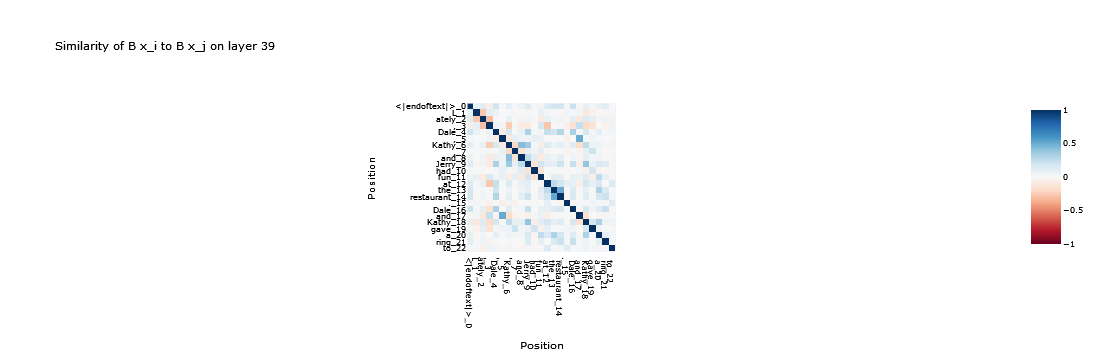

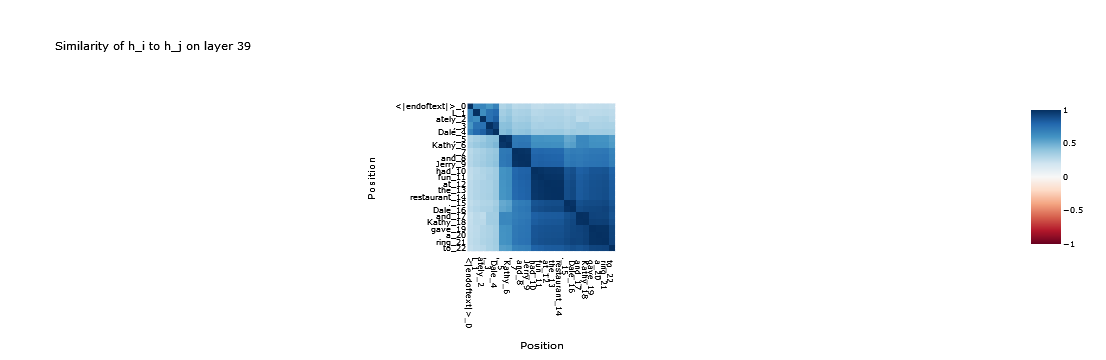

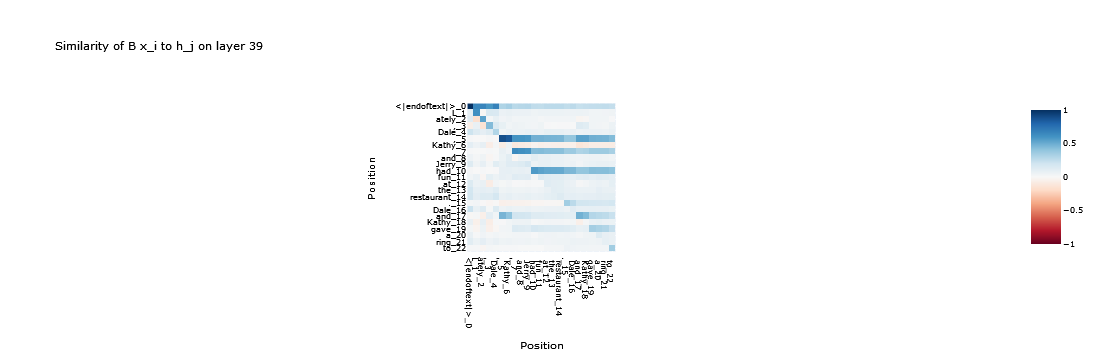

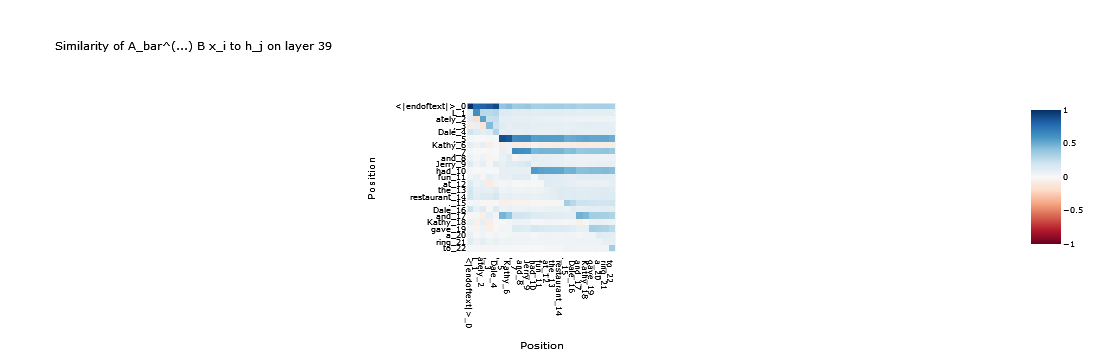

In [26]:

prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

# for each pos
'''
layer_labels = [str(layer) for layer in limited_layers]
for pos in tqdm(list(range(L))):
    fig = imshow(h_to_x_b_similarities[:,pos], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Similarity to hidden state of token = {token_labels[pos]}", font_size=8)
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.show()
'''
LAYER = 39
imshow(x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to B x_j on layer {LAYER}", font_size=8).show()
imshow(h_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of h_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities_catchup[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of A_bar^(...) B x_i to h_j on layer {LAYER}", font_size=8).show()



## Interpreting Convs

In [17]:
TOP_N = 200


def get_conv_sims(all_tokens, layer_input_func):
    V,L,D,E = all_tokens.size()[0], 1, model.cfg.D, model.cfg.E
    D_conv = model.cfg.D_conv
    sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    cosine_sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    
    # todo: can we do the same thing for skip connection and B_bar (and maybe A_bar?)
    for INTERPRET_LAYER in tqdm(list(range(model.cfg.n_layers))):
        # [V,1,E]
        conv_input = layer_input_func(all_tokens=all_tokens, layer=INTERPRET_LAYER)
        # [E,1,D_CONV]
        conv_filters = model.blocks[INTERPRET_LAYER].conv1d.weight
        # [V,D]
        conv_input_vecs = conv_input[:,0,:]
        # [V,1]
        conv_input_vecs_mag = torch.linalg.norm(conv_input_vecs, ord=2, dim=1, keepdim=True)
        conv_input_vecs_mag[conv_input_vecs_mag==0] = 1.0 # prevent divide by zero
        # [V,D]                     [V,D]             [V,1]
        conv_input_normalized = conv_input_vecs * 1.0/conv_input_vecs_mag
        
        for conv_i in range(D_conv+1):
            if conv_i < D_conv:
                # [E,1]
                filter = conv_filters[:,0,conv_i].view(E,1)
            else:
                filter = model.blocks[INTERPRET_LAYER].conv1d.bias.view(E,1)
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_sims    = conv_input @ filter
            # [V]                                  [V]
            sims[INTERPRET_LAYER,:,conv_i] = filter_sims[:,0,0]
        
            # [1]
            filter_mag = torch.linalg.norm(filter.view(E), ord=2, dim=0, keepdim=True)
            filter_mag[filter_mag==0] = 1.0 # no divide by zero
            # [E,1]              [E,1]      [1]
            filter_normalized = filter / filter_mag
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_cosine_sims    = conv_input_normalized.view(V,1,E) @ filter_normalized
            cosine_sims[INTERPRET_LAYER,:,conv_i] = filter_cosine_sims[:,0,0]
    return sims, cosine_sims

def simple_projected_input(all_tokens, layer):
    # [V,L,D]
    V = all_tokens.size()[0]
    L = 1
    D = model.cfg.D
    input = model.embedding.weight[all_tokens].view(V,L,D)
    # [V,L,D]                                  [V,L,D]
    normalized_input = model.blocks[layer].norm(input)
    # [V,L,E]                        [D->E]     [V,L,D]
    conv_input = model.blocks[layer].in_proj(normalized_input)
    return conv_input

all_tokens = torch.arange(model.cfg.V, device=model.cfg.device)
print(all_tokens.size())
sims, cosine_sims = get_conv_sims(all_tokens=all_tokens, layer_input_func=simple_projected_input)

import pathlib

pathlib.Path("conv interp").mkdir(parents=True, exist_ok=True)
D_conv = model.cfg.D_conv
for INTERPRET_LAYER in range(model.cfg.n_layers):
    with open(f"conv interp/layer {INTERPRET_LAYER} conv sims all.txt", "w") as f:
        def write(s):
            f.write(s + "\n")
        write(f"layer {INTERPRET_LAYER}")
        for conv_i in range(D_conv+1):
            if conv_i == 0: continue # this one is always zeros for some reason
            if conv_i < D_conv:
                write(f"    conv filter {conv_i}")
            else:
                write(f"    bias")
            write(f"      unnormalized sims:")
            top_n = torch.argsort(-sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {sims[INTERPRET_LAYER,tok_i,conv_i]}")
            write(f"      cosine sims:")
            top_n = torch.argsort(-cosine_sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {cosine_sims[INTERPRET_LAYER,tok_i,conv_i]}")
        

torch.Size([50280])


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

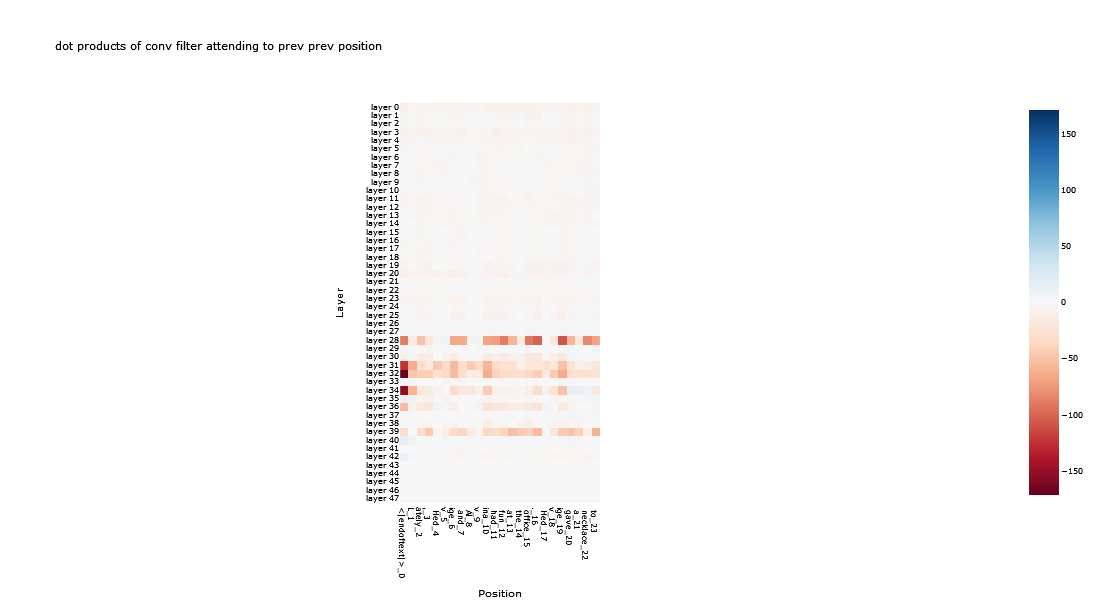

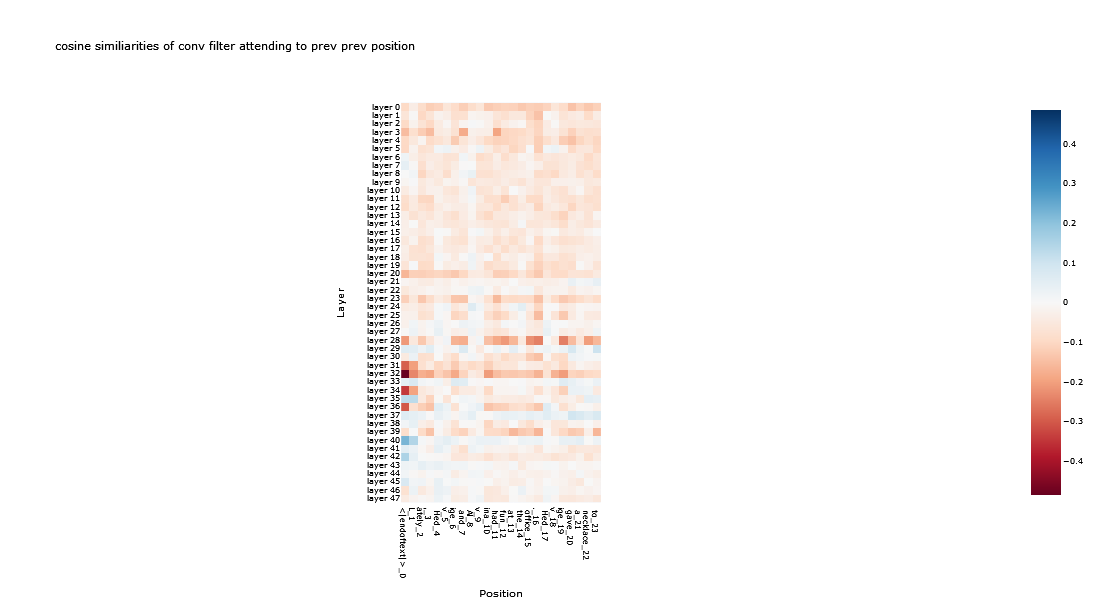

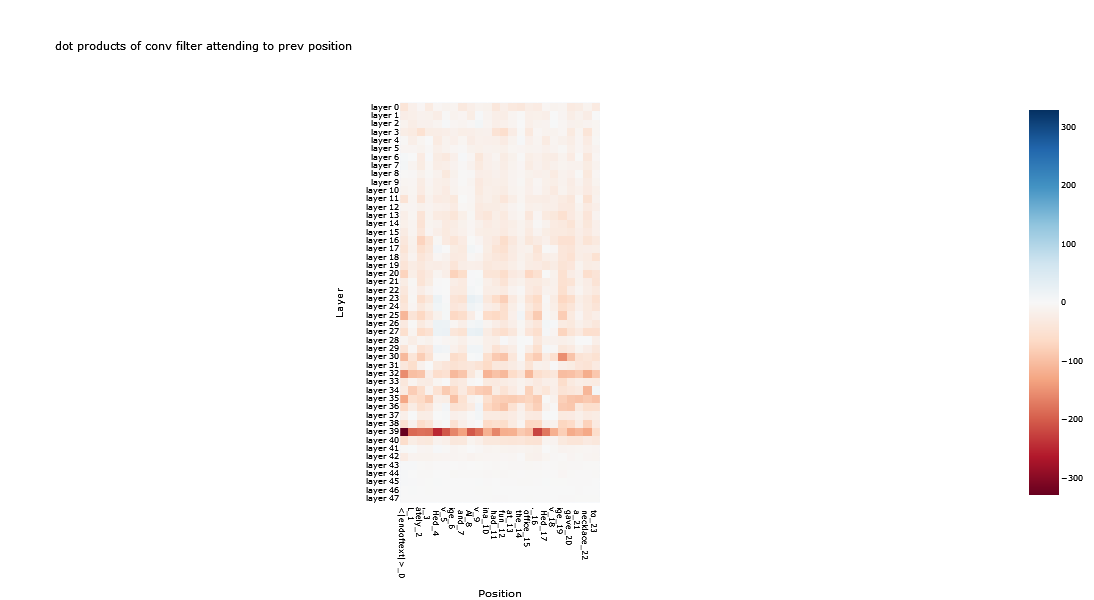

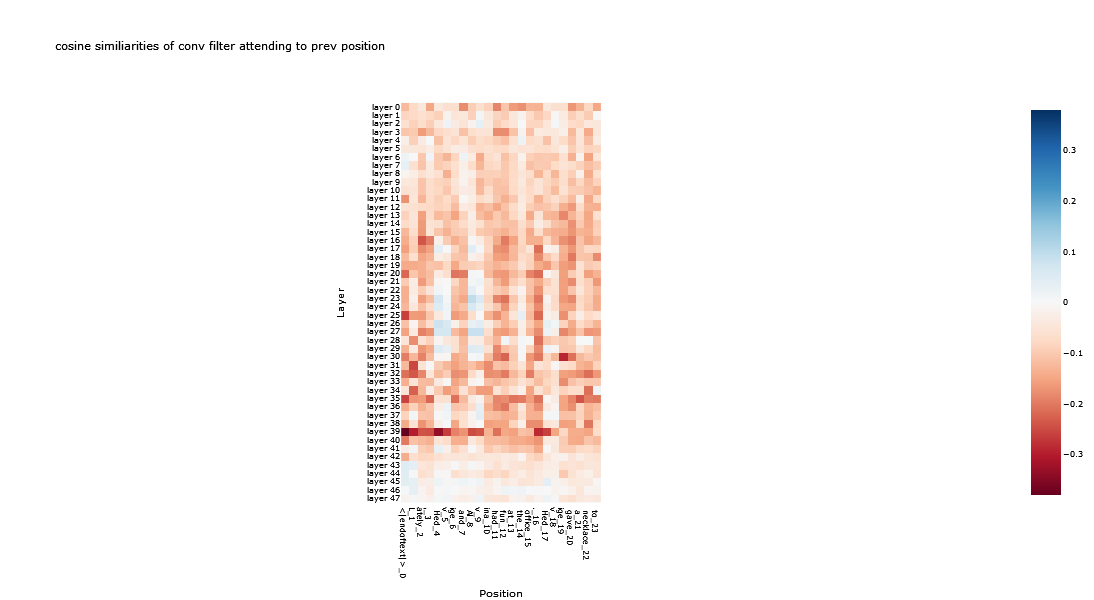

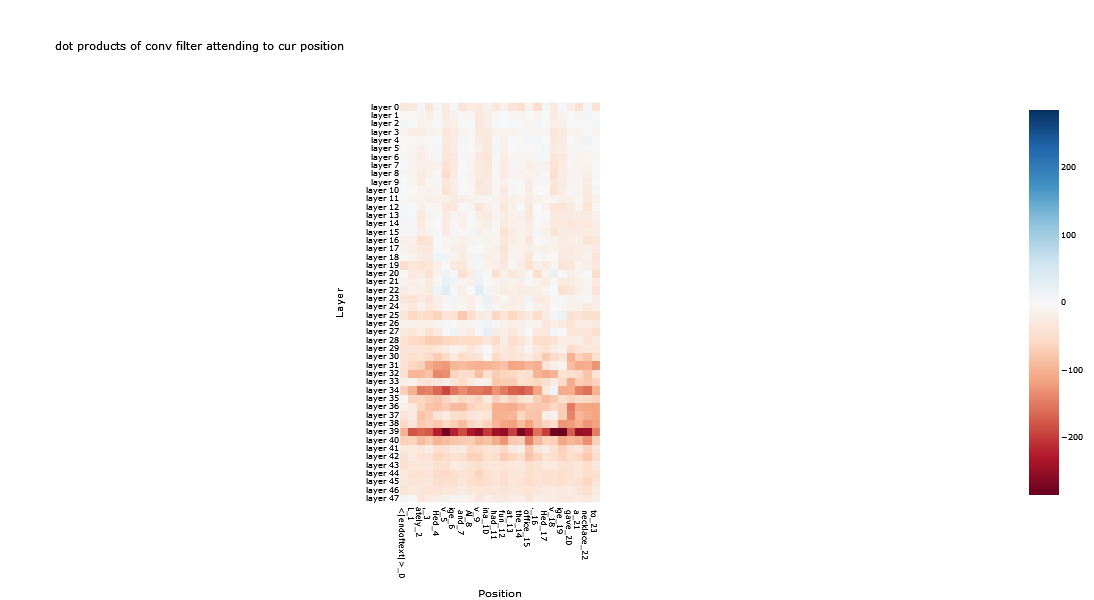

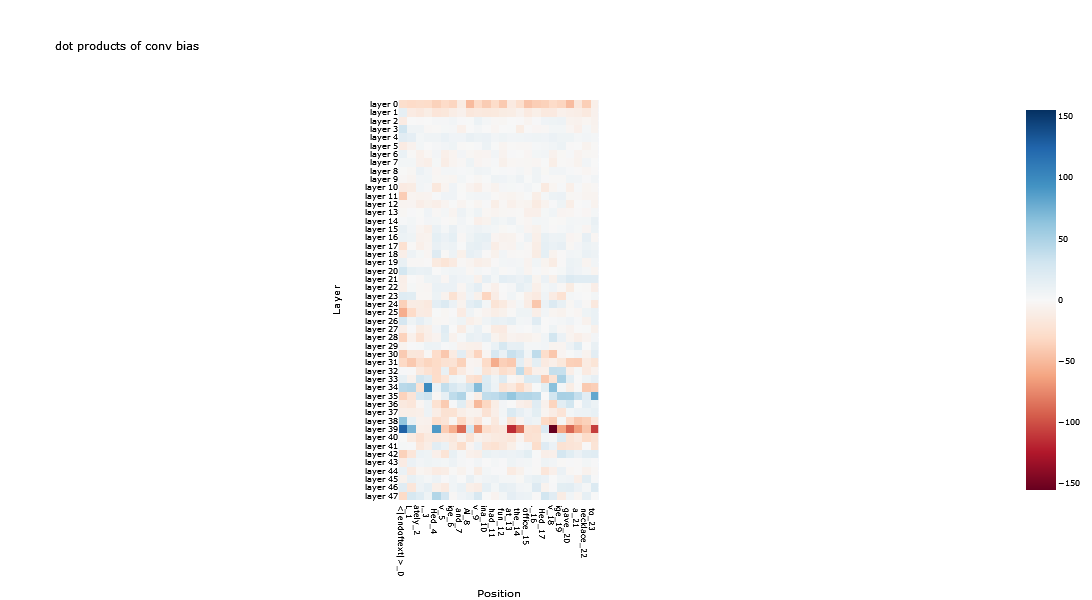

In [18]:
prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

in_proj_names = []
for layer in range(model.cfg.n_layers):
    in_proj_names.append(f'blocks.{layer}.hook_in_proj')
logits, activations = model.run_with_cache(prompt_tokens.view(1,-1), names_filter=in_proj_names)

def hooked_layer_inputs(all_tokens, layer):
    # [B,L,E]
    conv_input = activations[f'blocks.{layer}.hook_in_proj']
    B,L,E = conv_input.size()
    return conv_input[0].view(L,1,E)
    
all_tokens = prompt_tokens

sims, cosine_sims = get_conv_sims(all_tokens=prompt_tokens, layer_input_func=hooked_layer_inputs)

conv_name_lookup = ['conv filter attending to cur position', 'conv bias']
for i in range(D_conv-1):
    conv_name_lookup = ["conv filter attending to " + " ".join(['prev']*(i+1)) + " position"] + conv_name_lookup
layer_labels = [f"layer {i}" for i in range(model.cfg.n_layers)]
for conv_i in range(D_conv+1):
    if conv_i == 0: continue # the first conv is always zero for some reason
    conv_str = f"{conv_name_lookup[conv_i]}"
    imshow(sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"dot products of {conv_str}", font_size=8)
    imshow(cosine_sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"cosine similiarities of {conv_str}", font_size=8)



## Batched Patching

In [91]:
# modified from neel nanda's examples

# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
clean_hooks(model)

H_N_PATCHING_LAYER = 39
BATCH_SIZE = 10000

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
#limited_layers = [0, 3, 7, 10, 11, 14, 15, 16, 17, 19, 21, 23, 25, 26, 27, 28, 30, 33, 34, 39, 40, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]
#limited_layers = list(range(40)) + [40, 45, 46]
limited_layers = [0, 1, 7, 12, 16, 18, 20, 21, 24, 28, 33, 39, 44, 45]

limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus



# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, layers_to_patch_on, patch_positions=None, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(layers_to_patch_on)

    num_results = n_layers
    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_results = n_layers
    elif patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    num_data_points = batched_data.size()[0]//2

    if patch_positions is None:
        patch_positions = list(range(L))
        
    num_positions = len(patch_positions)

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_positions = n_layers # does layer x layer
    
    patching_result_normalized_logits = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    
    hooks = []

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_out_proj', partial(layer_output_storage_acdc_layer_edge_hook, layer=layer)))
        
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))

    BATCH_OFFSET = 2 # first two are for uncorrupted and corrupted

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        batch = 0
        indices = []
        for i,input_layer in enumerate(layers_to_patch_on):
            for j,output_layer in enumerate(layers_to_patch_on):
                patching_hook_name = patching_hook_name_func(layer=output_layer, position=None)
                if input_layer >= output_layer: continue # only do i->j where i < j
                patching_hook = partial(patching_hook_func, input_layer=input_layer, output_layer=output_layer, batch=batch+BATCH_OFFSET)
                indices.append((i,j))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch+BATCH_OFFSET)
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in enumerate(layers_to_patch_on):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in patch_positions:
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET, conv_filter_i=conv_filter_i)
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                    batch += 1
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in enumerate(layers_to_patch_on):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET)
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)

    for uncorrupted_i in tqdm(list(range(0,batched_data.size()[0],2))):
        corrupted_i = uncorrupted_i+1
        result_i = uncorrupted_i//2
        # [1+len(indicies),L]
        uncorrupted_data = batched_data[uncorrupted_i:uncorrupted_i+1]
        corrupted_data = batched_data[corrupted_i:corrupted_i+1]
            
        if batch_size != BATCH_SIZE_ALL:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((int(batch_size),1))], dim=0)
            V = model.cfg.V
            patched_logits = torch.zeros([len(indices)+2, L, V])
            for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
                batch_end = min(len(indices), batch_start+int(batch_size))
                batch_hooks = hooks[batch_start:batch_end]
                cur_batch_size = batch_end-batch_start
                output_logits = model.run_with_hooks(run_data, fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
                if batch_start == 0:
                    patched_logits[0:2] = output_logits[:2]
                patched_logits[batch_start+2:batch_end+2] = output_logits[2:][:cur_batch_size] # skip the first two which are for uncorrupted and corrupted
        else:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((len(indices),1))], dim=0)
            # [B,L,V]
            patched_logits = model.run_with_hooks(run_data, fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
       
        # [B,L,V]
        patched_prs = torch.softmax(patched_logits, dim=2)

        # [B,L,V]
        uncorrupted_logits = patched_logits[0:1]
        uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
        uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

        # [B,L,V]
        corrupted_logits = patched_logits[1:2]
        corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        corrupted_prs = torch.softmax(corrupted_logits, dim=2)
        corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        
        
        for b_, (i,position) in enumerate(indices):
            b = b_+2 # the first and second position is reserved for uncorrupted and corrupted, respectively
            if corrupted_answer != uncorrupted_answer:
                # diff is logit of uncorrupted_answer - logit of corrupted_answer
                # we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
                # we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
                # thus we can treat these as (rough) min and max possible values

                min_logit_diff = corrupted_logit_diff
                max_logit_diff = uncorrupted_logit_diff
                
                min_pr_diff = corrupted_pr_diff
                max_pr_diff = uncorrupted_pr_diff

                
                patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                             uncorrupted_answer=uncorrupted_answer,
                                                                             corrupted_answer=corrupted_answer)
                # normalize it so
                # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
                # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
                normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
                # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
                # so now
                # 0 means that it is acting like the uncorrupted model
                # 1 means that it is acting like the corrupted model
                normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
                patching_result_normalized_logits[uncorrupted_i//2, i, position] += normalized_patched_logit_diff
                
                # same for pr
                patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                    uncorrupted_answer=uncorrupted_answer,
                                                                    corrupted_answer=corrupted_answer)
                normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
                patching_result_normalized_prs[uncorrupted_i//2, i, position] += normalized_patched_pr_diff
    
            for k, answer_token in enumerate(answer_tokens):
                patching_result_logits[uncorrupted_i//2, i, position, k] += patched_logits[b,-1,answer_token]
                patching_result_prs[uncorrupted_i//2, i, position, k] += patched_prs[b,-1,answer_token]

    if show_plot:
        print("done patching, displaying results...")
 
        if patching_type == H_N_PATCHING:
            layer_labels = [str(n) for n in range(N)]
        elif patching_type == CONV_FILTERS_PATCHING:
            layer_labels = []
            for layer in layers_to_patch_on:
                for conv_i in range(1, D_conv):
                    layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
        else:
            layer_labels = [str(layer) for layer in layers_to_patch_on]
        figs = []
        points_per_data_format = num_data_points//len(all_formats)
        for data_i, data_start in enumerate(range(0, num_data_points, points_per_data_format)):
            data_end = data_start+points_per_data_format

            # make token labels that describe the patch
            uncorrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2])
            corrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2+1])
            token_labels = []
            for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
                if corrupted_token == uncorrupted_token:
                    token_labels.append(f"{corrupted_token}_{index}")
                else:
                    token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

            # this just does layer x layer
            if patching_type == ACDC_LAYER_EDGE_PATCHING:
                token_labels = [str(layer) for layer in layers_to_patch_on] 
            
            # this annotation describes the patching format on the side
            ANNOTATION_FONT_SIZE = 10
            def add_annotation(fig, annotation):
                for i, line in enumerate(annotation.split("\n")):
                    fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                                        x=0,
                                        y=0.9-i*0.05,
                                        showarrow=False,
                                        text=line,
                                        textangle=0,
                                        xanchor='left',
                                        yanchor='bottom',
                                        xref="paper",
                                        yref="paper"))
            
            if corrupted_answer != uncorrupted_answer:
                if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_logits[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
                if show_options in [SHOW_PR, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_prs[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
            data_format = all_formats[data_i]
            format_path = "patching_outputs/" + data_format.replace("\n", "   ")
            pathlib.Path(format_path).mkdir(parents=True, exist_ok=True)
            figs[-1].write_image(format_path + "/" + patching_type + ".png")

        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        
        for k, answer_token in enumerate(answer_tokens):
            if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                figs.append(imshow(patching_result_logits.mean(dim=0)[:,:,k], fix_size=True, color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
            if show_options in [SHOW_PR, SHOW_BOTH]:
                figs.append(imshow(patching_result_prs.mean(dim=0)[:,:,k], fix_size=True, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 
    
        for fig in figs:
            fig.show()
    return patching_result_normalized_logits, patching_result_normalized_prs, patching_result_logits, patching_result_prs

CORRUPTED_BATCH = 1

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [E,L]                                   [E,1]                             [E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[CORRUPTED_BATCH,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for ACDC layer edge step
def layer_input_acdc_layer_edge_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    input_layer: int,
    output_layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    input_resid_uncorrupted = storage[input_layer][0]
    input_resid_corrupted = storage[input_layer][1]
    layer_input_out = layer_input.clone()
    # remove the uncorrupted and add the corrupted
    layer_input[batch] = layer_input[batch]-input_resid_uncorrupted+input_resid_corrupted
    return layer_input

# hook_out_proj is the term added to the resid
def layer_output_storage_acdc_layer_edge_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    if layer == 0:
        storage = {}
    storage[layer] = layer_output[:2] # first two are uncorrupted and corrupted, we only need those nothing else
    return layer_output





## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
    position: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    x[batch, position, :] = x[CORRUPTED_BATCH, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch] = h[CORRUPTED_BATCH]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch,:,n] = h[CORRUPTED_BATCH,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'
ACDC_LAYER_EDGE_PATCHING = 'acdc layer edge'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
    ACDC_LAYER_EDGE_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_layer_input', layer_input_acdc_layer_edge_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)
def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     layers_to_patch_on=limited_layers,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)


# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


baseline correct relative pr 0.8733358383178711 incorrect relative pr 0.1266641616821289 accuracy 0.92
uncorrupted prompt
Lately, Kate, Chelsea, and Pam had fun at the house. Chelsea and Pam gave a necklace to
' Kate' logit 12.060500144958496
' Kate' pr 0.0462447889149189
' Olive' logit 4.769355773925781
' Olive' pr 3.151802593492903e-05

corrupted prompt
Lately, Olive, Chelsea, and Pam had fun at the house. Chelsea and Pam gave a necklace to
' Kate' logit 8.108930587768555
' Kate' pr 0.0004152756300754845
' Olive' logit 10.760531425476074
' Olive' pr 0.005887244362384081


Dropdown(description='Patching Type', options=('normalized input', 'layer input', 'skip', 'in proj', 'conv fil…

Dropdown(description='batch size', options=('all', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11…

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

## Layer Patching

In [29]:

BATCH_SIZE = 1000

# todo: double up things but swapped, so it's symmetric
def patch_layer_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, layer_output.size()[0], 2):
        layer_output[i] = layer_output[i+1]
    return layer_output

#limited_layer_set = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]

def wrap_patch_specific_layers(model, layers_to_patch, **kwargs):
    hooks = []
    for layer in layers_to_patch:
        hooks.append((f"blocks.{layer}.hook_out_proj", patch_layer_hook))
    
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    wrapper.cfg = model.cfg
    return wrapper

print(f"constraining output to answers? {constrain_to_answers}")
print(f"symmetric patching? {has_symmetric_patching}")

print(f"num layers {model.cfg.n_layers}")

        
pbatched_data = repeat_swapped_patch(batched_data, has_symmetric_patching=has_symmetric_patching)
pbatched_correct = repeat_swapped_patch(batched_correct, has_symmetric_patching=has_symmetric_patching)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect, has_symmetric_patching=has_symmetric_patching)
vpbatched_data = repeat_swapped_patch(vbatched_data, has_symmetric_patching=has_symmetric_patching)
vpbatched_correct = repeat_swapped_patch(vbatched_correct, has_symmetric_patching=has_symmetric_patching)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect, has_symmetric_patching=has_symmetric_patching)


history = []
history_stats = []
layers_to_patch = []

while len(layers_to_patch) < model.cfg.n_layers:
    remaining_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_patch:
        remaining_layers.remove(layer)
    print("layers not patched", remaining_layers)
    print("layers patched", layers_to_patch)
    correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=layers_to_patch, fast_ssm=True, fast_conv=True),
                                    vpbatched_data, vpbatched_correct, vpbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    
    out_acc = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(remaining_layers)], device=model.cfg.device)
        
    for i, start_layer in tqdm(list(enumerate(remaining_layers))):
        #layers = list(range(start_layer, end_layer+1))
        patching_layers = layers_to_patch + [start_layer]
        
        correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=patching_layers, fast_ssm=True, fast_conv=True),
                                    pbatched_data, pbatched_correct, pbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc

    print(out_acc)
    best_layer_to_patch = remaining_layers[torch.argsort(-out_acc)[0]]
    print("patching layer", best_layer_to_patch, f"with acc {out_acc[remaining_layers.index(best_layer_to_patch)]}")
    layers_to_patch.append(best_layer_to_patch)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
layers not patched [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
layers patched []
correct relative pr 0.786421537399292 incorrect relative pr 0.2135784775018692 accuracy 0.91


  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Layer Removal

In [28]:
BATCH_SIZE = 1000

# zero ablating the value that is added to resid is the same as removing the layer
def hook_out_proj_layer_skip_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    return torch.zeros(resid_pre.size(), device=model.cfg.device)

def only_use_these_layers_hooks(model, only_use_these_layers):
    layers_to_skip = list(range(model.cfg.n_layers))
    for layer in only_use_these_layers:
        if layer in layers_to_skip:
            layers_to_skip.remove(layer)
    skip_hooks = []
    for layer in layers_to_skip:
        skip_hooks.append((f"blocks.{layer}.hook_out_proj", hook_out_proj_layer_skip_hook))
    return skip_hooks

def wrap_model_only_layers(model, only_use_these_layers, **kwargs):
    def model_wrapper(input, **kwargs):
        #skip_hooks = only_use_these_layers_hooks(model=model, only_use_these_layers=only_use_these_layers)
        return model.run_with_hooks(input, fwd_hooks=[], only_use_these_layers=only_use_these_layers, **kwargs)
    model_wrapper.tokenizer = model.tokenizer # hack because we use the tokenizer for inference to get pad token
    return model_wrapper


print(f"constraining output to answers? {constrain_to_answers}")
print(f"symmetric patching? {has_symmetric_patching}")

print(f"num layers {model.cfg.n_layers}")

ACC_LOWER_BOUND = 0.98
history = []
history_stats = []
layers_to_remove = []
prev_found_layer = 0

while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True),
                                    vbatched_data, vbatched_correct, vbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=not has_symmetric_patching) # we need this for asymmetric patching where the patched data is too easy
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    out_acc = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(base_layers)], device=model.cfg.device)

    found_layer = None

    # this is for skipping ahead
    for i, start_layer in tqdm(list(enumerate(base_layers))):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)
        
        correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=layers, fast_ssm=True, fast_conv=True),
                                    batched_data, batched_correct, batched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=not has_symmetric_patching)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        if acc > ACC_LOWER_BOUND:
            found_layer = start_layer
            prev_found_layer = found_layer
            layers_to_remove.append(found_layer)
            print("removing layer", found_layer, "with accuracy", acc)
            break
    if found_layer is None:
        prev_found_layer = 0
        print(out_acc)
        best_layer_to_remove = base_layers[torch.argsort(-out_acc)[0]]
        print("removing layer", best_layer_to_remove)
        layer_names = [f'layer {x}' for x in base_layers]
        layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

constraining output to answers? False
symmetric patching? False
num layers 48
correct pr 0.9654136300086975 incorrect pr 0.0335070826113224 accuracy 1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/48 [00:00<?, ?it/s]

removing layer 1 with accuracy 1.0
correct pr 0.9551305174827576 incorrect pr 0.043733466416597366 accuracy 1.0
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/47 [00:00<?, ?it/s]

removing layer 2 with accuracy 1.0
correct pr 0.9198064208030701 incorrect pr 0.0777411088347435 accuracy 0.988
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/46 [00:00<?, ?it/s]

removing layer 3 with accuracy 0.996
correct pr 0.9167128205299377 incorrect pr 0.08033338189125061 accuracy 0.996
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/45 [00:00<?, ?it/s]

removing layer 4 with accuracy 0.988
correct pr 0.9091572761535645 incorrect pr 0.08714482188224792 accuracy 0.996
[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/44 [00:00<?, ?it/s]

removing layer 5 with accuracy 1.0
correct pr 0.9050810933113098 incorrect pr 0.09041441977024078 accuracy 0.992
[0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/43 [00:00<?, ?it/s]

removing layer 6 with accuracy 1.0
correct pr 0.9177960753440857 incorrect pr 0.07795935124158859 accuracy 0.992
[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/42 [00:00<?, ?it/s]

removing layer 7 with accuracy 1.0
correct pr 0.9399835467338562 incorrect pr 0.04962770268321037 accuracy 1.0
[0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/41 [00:00<?, ?it/s]

removing layer 8 with accuracy 0.996
correct pr 0.9389967918395996 incorrect pr 0.04780060797929764 accuracy 1.0
[0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/40 [00:00<?, ?it/s]

removing layer 9 with accuracy 1.0
correct pr 0.9372789859771729 incorrect pr 0.04293254390358925 accuracy 1.0
[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/39 [00:00<?, ?it/s]

removing layer 10 with accuracy 0.996
correct pr 0.9265281558036804 incorrect pr 0.05483777076005936 accuracy 0.996
[0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/38 [00:00<?, ?it/s]

removing layer 13 with accuracy 0.996
correct pr 0.8689068555831909 incorrect pr 0.08188582211732864 accuracy 0.996
[0, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/37 [00:00<?, ?it/s]

removing layer 12 with accuracy 0.992
correct pr 0.8079679012298584 incorrect pr 0.0881195142865181 accuracy 0.98
[0, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/36 [00:00<?, ?it/s]

removing layer 16 with accuracy 0.996
correct pr 0.7901766896247864 incorrect pr 0.1306191235780716 accuracy 0.992
[0, 11, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/35 [00:00<?, ?it/s]

removing layer 18 with accuracy 0.996
correct pr 0.7610023617744446 incorrect pr 0.12966245412826538 accuracy 0.996
[0, 11, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/34 [00:00<?, ?it/s]

removing layer 19 with accuracy 0.992
correct pr 0.7642690539360046 incorrect pr 0.1453825831413269 accuracy 0.996
[0, 11, 14, 15, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/33 [00:00<?, ?it/s]

removing layer 23 with accuracy 0.996
correct pr 0.7979890704154968 incorrect pr 0.14878545701503754 accuracy 1.0
[0, 11, 14, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/32 [00:00<?, ?it/s]

removing layer 14 with accuracy 0.984
correct pr 0.7183040976524353 incorrect pr 0.19686897099018097 accuracy 0.968
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/31 [00:00<?, ?it/s]

removing layer 35 with accuracy 0.984
correct pr 0.7559100985527039 incorrect pr 0.14410626888275146 accuracy 0.972
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/30 [00:00<?, ?it/s]

removing layer 41 with accuracy 0.988
correct pr 0.7303114533424377 incorrect pr 0.1653570830821991 accuracy 0.976
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47]


  0%|          | 0/29 [00:00<?, ?it/s]

removing layer 32 with accuracy 0.984
correct pr 0.6847578287124634 incorrect pr 0.16154319047927856 accuracy 0.96
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47]


  0%|          | 0/28 [00:00<?, ?it/s]

removing layer 42 with accuracy 0.984
correct pr 0.7091242074966431 incorrect pr 0.17167718708515167 accuracy 0.976
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47]


  0%|          | 0/27 [00:00<?, ?it/s]

tensor([0.0040, 0.3040, 0.5920, 0.9240, 0.9680, 0.9480, 0.9680, 0.9720, 0.9440,
        0.9360, 0.9560, 0.9640, 0.9560, 0.9760, 0.9440, 0.9520, 0.9400, 0.4800,
        0.9680, 0.9800, 0.9560, 0.9680, 0.9480, 0.9000, 0.8240, 0.8440, 0.9120],
       device='cuda:0')
removing layer 38
correct pr 0.7017506957054138 incorrect pr 0.1755971610546112 accuracy 0.984
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 39, 40, 43, 44, 45, 46, 47]


  0%|          | 0/26 [00:00<?, ?it/s]

tensor([0.0000, 0.3680, 0.6000, 0.9560, 0.9440, 0.9440, 0.9680, 0.9680, 0.9680,
        0.9640, 0.9600, 0.9680, 0.9560, 0.9560, 0.9560, 0.9600, 0.9640, 0.4360,
        0.9520, 0.9440, 0.9760, 0.9200, 0.8720, 0.7200, 0.7400, 0.8400],
       device='cuda:0')
removing layer 40
correct pr 0.7113022804260254 incorrect pr 0.15403729677200317 accuracy 0.968
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/25 [00:00<?, ?it/s]

tensor([0.0000, 0.3480, 0.6480, 0.9120, 0.9560, 0.9680, 0.9720, 0.9600, 0.9440,
        0.9560, 0.9720, 0.9640, 0.9520, 0.9760, 0.9440, 0.9560, 0.9400, 0.5120,
        0.9440, 0.9120, 0.8800, 0.7760, 0.7200, 0.5880, 0.7760],
       device='cuda:0')
removing layer 30
correct pr 0.6950139403343201 incorrect pr 0.10626452416181564 accuracy 0.956
[0, 11, 15, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0.0000, 0.4280, 0.3960, 0.8560, 0.9200, 0.9480, 0.9720, 0.9240, 0.9000,
        0.9560, 0.9440, 0.9160, 0.9080, 0.9360, 0.9520, 0.8440, 0.5200, 0.9320,
        0.9160, 0.8480, 0.7600, 0.7480, 0.5520, 0.7520], device='cuda:0')
removing layer 22
correct pr 0.6762691140174866 incorrect pr 0.13484738767147064 accuracy 0.98
[0, 11, 15, 17, 20, 21, 24, 25, 26, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/23 [00:00<?, ?it/s]

tensor([0.0000, 0.0240, 0.4080, 0.7080, 0.7480, 0.8440, 0.9160, 0.7840, 0.9520,
        0.9360, 0.9320, 0.8280, 0.9080, 0.9200, 0.8680, 0.3840, 0.8640, 0.8560,
        0.9040, 0.8080, 0.5440, 0.7200, 0.7920], device='cuda:0')
removing layer 26
correct pr 0.5395902395248413 incorrect pr 0.23870113492012024 accuracy 0.904
[0, 11, 15, 17, 20, 21, 24, 25, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/22 [00:00<?, ?it/s]

tensor([0.0000, 0.0600, 0.3680, 0.6720, 0.8400, 0.8120, 0.8880, 0.8320, 0.9120,
        0.8600, 0.6800, 0.7800, 0.8840, 0.8040, 0.2840, 0.8880, 0.8400, 0.7960,
        0.5200, 0.5360, 0.6840, 0.6480], device='cuda:0')
removing layer 27
correct pr 0.5128080248832703 incorrect pr 0.24019557237625122 accuracy 0.924
[0, 11, 15, 17, 20, 21, 24, 25, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/21 [00:00<?, ?it/s]

tensor([0.0040, 0.0200, 0.3000, 0.4720, 0.8080, 0.7440, 0.7600, 0.7480, 0.8520,
        0.4320, 0.7200, 0.8320, 0.7440, 0.2600, 0.8280, 0.7840, 0.7640, 0.4360,
        0.5400, 0.6880, 0.6760], device='cuda:0')
removing layer 28
correct pr 0.4808506965637207 incorrect pr 0.22751544415950775 accuracy 0.852
[0, 11, 15, 17, 20, 21, 24, 25, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/20 [00:00<?, ?it/s]

tensor([0.0000, 0.0040, 0.1680, 0.4200, 0.6440, 0.6680, 0.6600, 0.6000, 0.2560,
        0.5120, 0.7680, 0.6480, 0.2480, 0.6920, 0.5840, 0.7120, 0.3560, 0.4800,
        0.6160, 0.6000], device='cuda:0')
removing layer 33
correct pr 0.5020119547843933 incorrect pr 0.23366618156433105 accuracy 0.756
[0, 11, 15, 17, 20, 21, 24, 25, 29, 31, 34, 36, 37, 39, 43, 44, 45, 46, 47]


  0%|          | 0/19 [00:00<?, ?it/s]

tensor([0.0000, 0.0000, 0.3160, 0.5560, 0.6040, 0.6160, 0.6120, 0.5120, 0.2400,
        0.6600, 0.5720, 0.3680, 0.6600, 0.6200, 0.6880, 0.3680, 0.3040, 0.5800,
        0.4000], device='cuda:0')
removing layer 43
correct pr 0.48595312237739563 incorrect pr 0.2477431446313858 accuracy 0.692
[0, 11, 15, 17, 20, 21, 24, 25, 29, 31, 34, 36, 37, 39, 44, 45, 46, 47]


  0%|          | 0/18 [00:00<?, ?it/s]

tensor([0.0000, 0.0000, 0.1240, 0.3720, 0.5200, 0.4600, 0.3560, 0.4160, 0.1920,
        0.4800, 0.4160, 0.2280, 0.4920, 0.5440, 0.1400, 0.1920, 0.4960, 0.4080],
       device='cuda:0')
removing layer 39
correct pr 0.37950843572616577 incorrect pr 0.26618748903274536 accuracy 0.552
[0, 11, 15, 17, 20, 21, 24, 25, 29, 31, 34, 36, 37, 44, 45, 46, 47]


  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Edge based ACDC on Layers

In [109]:
import pickle
import torch
from dataclasses import dataclass, field
from jaxtyping import Float
from typing import List, Dict, Callable, Union, Tuple
from functools import partial
from collections import defaultdict
from functools import partial
from transformer_lens.hook_points import HookPoint
import networkx as nx
import graphviz
from tqdm.notebook import tqdm

def get_pad_token(tokenizer):
    '''
    Retreives the pad token id from the tokenizer
    '''
    return tokenizer.pad_token_id


def index_into(data, indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this does what you'd want, it indexes them
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)

def eval_acdc(model, data, correct, incorrect, metric, num_edges, constrain_to_answers, **kwargs):
    num_examples = correct.size()[0]
    
    logits = model(data, **kwargs)[:,-1]

    # they come in pairs, uncorrupted, corrupted
    # we patch the first one in the pair, so only measure accuracy on that
    patched_logits = logits[::2]
    corrupted_logits = logits[1::2]
    patched_correct = correct[::2]
    patched_incorrect = incorrect[::2]
    
    pad = get_pad_token(tokenizer=model.tokenizer)
    logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
        
    n_data, n_correct = patched_correct.size()
    n_data, n_incorrect = patched_incorrect.size()
    
    # [n_data, n_correct]
    correct_logits = index_into(patched_logits, patched_correct)
    # [n_data, n_incorrect]
    incorrect_logits = index_into(patched_logits, patched_incorrect)
    
    if constrain_to_answers:
        # [n_data, n_correct + n_incorrect]
        combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
        combined_prs = torch.softmax(combined_logits, dim=1)
        biggest = torch.argsort(-combined_prs, dim=1)
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        has_correct = biggest[:,0] < n_correct

        correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
    else:
        prs = torch.nn.functional.softmax(patched_logits, dim=1)
        # [n_data, n_correct]
        correct_prs = index_into(prs, patched_correct)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, patched_incorrect)
        # [n_data, 1]
        top_tokens = torch.topk(patched_logits, 1, dim=1).indices
        # [n_data, n_correct]
        is_correct = top_tokens == patched_correct
        # [n_data]
        has_correct = torch.any(is_correct, dim=1)

    metric_results = torch.zeros([num_edges], device=model.cfg.device)
    batch_size = n_data//num_edges
    for i, batch_start in enumerate(range(0, n_data, batch_size)):
        batch_end = batch_start + batch_size
        metric_results[i] = metric(
            patched_logits=patched_logits[batch_start:batch_end],
            corrupted_logits=corrupted_logits[batch_start:batch_end],
            correct_logits=correct_logits[batch_start:batch_end],
            incorrect_logits=incorrect_logits[batch_start:batch_end],
            correct_prs=correct_prs[batch_start:batch_end],
            incorrect_prs=incorrect_prs[batch_start:batch_end],
            top_is_correct=has_correct[batch_start:batch_end],
        )
    return metric_results

def accuracy_metric(
    patched_logits,
    corrupted_logits,
    correct_logits,
    incorrect_logits,
    correct_prs,
    incorrect_prs,
    top_is_correct):
    return torch.sum(top_is_correct)/top_is_correct.size()[0]

@dataclass
class ACDCConfig:
    input_node: str
    output_node: str
    metric: Callable
    thresh: Float = 0.0001
    rollback_thresh: Float = 0.004
    batch_size: int = 4
    layers: List[int] = field(default_factory=lambda: None)
    model_kwargs: Dict = field(default_factory=lambda: {})
    log_level: str = 'info' # can be 'debug', 'info', 'none', or 'all'
    auto_hide_unused_default_edges: bool = True # edges with None for input and output hook will always be visible, this helps reduce clutter by hiding them if they have no path through them to output or through them to input
    merge_positions_in_graph_display: bool = True # if you have seperate edges 1,2,3,5,6 going from node A to node B, this will visually display them as a single edge labeled 1-3,5-6

@dataclass
class ACDCDataset:
    data: Float[torch.Tensor, "batch context_len"]
    correct: Float[torch.Tensor, "batch num_correct_answers"]
    incorrect: Float[torch.Tensor, "batch num_incorrect_answers"]
    valid_data: Float[torch.Tensor, "batch context_len"]
    valid_correct: Float[torch.Tensor, "batch num_correct_answers"]
    valid_incorrect: Float[torch.Tensor, "batch num_incorrect_answers"]
    constrain_to_answers: bool

@dataclass
class Edge:
    input_node: str
    output_node: str
    # these can either be a single tuple (hook_name, hook_func)
    # or a list of tuples [(hook_name_1, hook_func_1), (hook_name_2, hook_func_2), etc.]
    input_hook: Union[List[tuple[str, Callable]],tuple[str, Callable]] = None
    output_hook: Union[List[tuple[str, Callable]],tuple[str, Callable]] = None
    label: str = None
    patching: bool = False
    checked: bool = False
    score_diff_when_patched: Float = False

    def is_default_edge(self):
        '''
        some edges are "default on" if they have no hooks
        they are "default on" because if they have no hooks we can't test them
        '''
        return self.input_hook is None and self.output_hook is None
    
    def get_hooks(self, batch_start : int, batch_end : int) -> List[Tuple[str, HookPoint]]:
        '''
        Gets a list of hooks from this edge, in the format
        [(hook_name_1, hook_func_1), (hook_name_2, hook_func_2), ...]
        Hooks are given batch_start and batch_end as inputs,
        as well as the hook name(s) of the other side
        (so the input hook gets an output_hook_name param,
        and the output hook gets an input_hook_name param)
        '''
        hooks = []

        # this is all a bit cursed to optionally handle being passed a list of hooks instead of a single hook
        def extract_hooks(hook, **kwargs):
            if hook is None: return []
            res = []
            if type(hook) is list:
                for h in hook:
                    res += extract_hooks(h, **kwargs)
            else:
                res.append((hook[0], partial(hook[1], **kwargs)))
            return res
        
        inputs = extract_hooks(self.input_hook, output_hook_name=None, batch_start=batch_start, batch_end=batch_end)
        outputs = extract_hooks(self.output_hook, input_hook_name=None, batch_start=batch_start, batch_end=batch_end)

        def extract_name(hooks_extracting_from):
            if len(hooks_extracting_from) == 0: return None
            
            res = [hook_name for (hook_name, hook_func) in hooks_extracting_from]
            if len(res) == 1: # if single hook, return it (not a list containing it)
                return res[0]
            else: # else we need to return list of names
                return res

        input_names = extract_name(inputs)
        output_names = extract_name(outputs)
        
        hooks += extract_hooks(self.input_hook, output_hook_name=output_names, batch_start=batch_start, batch_end=batch_end)
        hooks += extract_hooks(self.output_hook, input_hook_name=input_names, batch_start=batch_start, batch_end=batch_end)
        
        return hooks

    def __str__(self):
        has_label = self.label is not None and not self.label == 'None' and not len(self.label.strip()) == 0 
        label_str = self.label + " " if has_label else ""
        return f"edge {label_str} {self.input_node} -> {self.output_node} ({self.input_hook} -> {self.output_hook}))"

@dataclass
class Node:
    name: str
    incoming_edges: List[Edge] = field(default_factory=lambda: [])
    outgoing_edges: List[Edge] = field(default_factory=lambda: [])


def get_edges_to_check(edges : List[Edge], nodes : Dict[str, Node]):
    '''
    Returns edges that should be considered next for pruning by acdc
    This starts at the things going into the sink and works backward
    '''
    # goal is to find edges that have no path through them to some other unchecked edge
    # we could just topological sort and pick first edge that is unchecked
    # but we want to batch multiple edges
    # so what we do is:

    # 1. mark all edges as not ready to check
    for edge in edges:
        edge.ready_to_check = False
    
    # 2. start and mark any edges that go to sink nodes (nodes with no outgoing edges) as "ready_to_check"
    for node in nodes.values():
        if len(node.outgoing_edges) == 0: # if sink node  
            for edge in node.incoming_edges:
                edge.ready_to_check = True

    modified = True
    while modified:
        modified = False
        # 3. For every node:
        #      if all outgoing edges are ready_to_check and checked, we can mark all incoming edges as ready_to_check
        for node in nodes.values():
            all_outgoing_completed = all([outgoing_edge.checked and outgoing_edge.ready_to_check for outgoing_edge in node.outgoing_edges])
            if all_outgoing_completed:
                for edge in node.incoming_edges:
                    if not edge.ready_to_check:
                        modified = True
                        edge.ready_to_check = True
        # repeat until we have no more edges modified

    # now all edges that are ready_to_check and not checked are the ones on the frontier we want
    # they have no paths through them to other unchecked edges
    for edge in edges:
        if edge.ready_to_check and not edge.checked:
            yield edge

    ''' this simplified version works if edges only get checked starting from the end, but this doesn't hold when we have implicit edges
    for node_name, node in sorted(list(all_nodes.items())):
        # if we have checked all our outgoing edges (or we have none), we are safe to expand incoming edges
        all_outgoing_checked = all([outgoing_edge.checked for outgoing_edge in node.outgoing_edges])
        if all_outgoing_checked:
            for edge in node.incoming_edges:
                if not edge.checked:
                    yield edge
    '''


def get_nx_graph(edges : List[Edge], include_unchecked : bool = False) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    G = nx.DiGraph()
    labeldict = defaultdict(lambda: set())
    for edge in edges:
        if (edge.checked and not edge.patching) or (not edge.checked and include_unchecked):
            G.add_edge(edge.input_node, edge.output_node, label=edge.label)
    return G

def draw_nx_graph(edges : List[Edge]):
    '''
    Uses networkx to draw the graph
    '''
    import matplotlib.pyplot as plt
    G = get_nx_graph(edges=edges)
    nx.draw_networkx(G, with_labels=True, font_size=8)
    plt.show()


def merge_positions(positions : List[int]) -> str:
    '''
    [0,1,2,4,5,6,8] -> "0-2,4-6,8"
    '''
    if len(positions) == 0: return ""
    
    L = max(positions)+1
    
    is_visited = [False for _ in range(L)]
    for p in positions:
        is_visited[p] = True
    

    ranges = []
    earliest = min(positions)
    start_pos = earliest
    started_range = True
    for pos in range(earliest+1, L):
        if not is_visited[pos] and started_range:
            ranges.append((start_pos, pos-1))
            started_range = False
        elif is_visited[pos] and not started_range:
            start_pos = pos
            started_range = True
    if started_range:
        ranges.append((start_pos, L-1))
    out_strs = []
    for (start_pos, end_pos) in ranges:
        if start_pos == end_pos:
            out_strs.append(str(start_pos))
        else:
            out_strs.append(str(start_pos) + "-" + str(end_pos))
    out_str = ",".join(out_strs)
    return out_str

def has_path_to_terminal_nodes(
        input_node : str,
        output_node : str,
        edges : List[Edge],
        edges_to_check : List[Edge],
        include_unchecked=False,
        ignore_not_present=True
    ) -> List[Tuple[bool, bool]]:
    '''
    Returns a list of tuples (connected_to_input, connected_to_output)
    where the item i in that list corresponds to edges_to_check[i]
    and whether it has a path to input_node (connected_to_input) or
    output_node (connected_to_output)

    edges is used to construct the graph, which by default only considers edges
    that have checked=True and patching=False
    if include_unchecked=True, this graph will also include any edge with checked=False

    if ignore_not_present=False, exceptions will be thrown if the graph does not contain
    input_node or output_node
    '''
    import networkx as nx
    G = get_nx_graph(edges=edges, include_unchecked=include_unchecked)
    connected_to = []
    for edge in edges_to_check:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=input_node, target=edge.input_node)
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            if not ignore_not_present:
                raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=edge.output_node, target=output_node)
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            if not ignore_not_present:
                raise ValueError(f"Graph does not have output node {output_node}")
        connected_to.append((connected_to_input, connected_to_output))
    return connected_to
    
def get_graphviz_graph(cfg : ACDCConfig, edges : List[Edge]) -> graphviz.Digraph:
    '''
    Returns a graphviz.Digraph representing edges.
    If cfg.merge_positions is True, condense_positions will be used to visually simplify the graph a little
    If cfg.auto_hide_unused_default_edges is True, default edges (those with no input_hook and no output_hook) 
    will only be shown if they have a path to the input or a path to the output (this makes the graph cleaner)
    '''
    dot = graphviz.Digraph('result')
    node_connections = defaultdict(lambda: [])
    displaying_nodes = set()
    default_edges = []
    num_edges = 0
    def add_edge(edge):
        if not edge.label is None and len(edge.label) > 0 and 'None' != edge.label: # the 'None' happens when positions = [None]
            try:
                # this needs to be two lines because otherwise it'll populate the default dict on exception and add a ghost edge
                val = int(edge.label) 
                if cfg.merge_positions_in_graph_display:
                    node_connections[(edge.input_node, edge.output_node)].append(val)
                else:
                    dot.edge(edge.input_node, edge.output_node, label=edge.label)
            except ValueError: # can't convert to int, just print the str
                dot.edge(edge.input_node, edge.output_node, label=edge.label)
        else:
            dot.edge(edge.input_node, edge.output_node)
    
    for edge in edges:
        if edge.checked and not edge.patching:
            if cfg.auto_hide_unused_default_edges and edge.is_default_edge():
                default_edges.append(edge)
            else:
                add_edge(edge)
                num_edges += 1
                displaying_nodes.add(edge.input_node)
                displaying_nodes.add(edge.output_node)

    # only display these if they have path to input or path to output
    # otherwise it's a lot of clutter
    for edge, (connected_to_input, connected_to_output) in zip(default_edges, has_path_to_terminal_nodes(input_node=cfg.input_node, output_node=cfg.output_node, edges=edges, edges_to_check=default_edges)):
        if connected_to_input or connected_to_output:
            add_edge(edge)
            num_edges += 1

    # with things like [1,2,3,4,7,8] we turn them into 1-4,7-8
    for (input_node, output_node), positions in node_connections.items():
        positions = sorted(list(positions))
        dot.edge(input_node, output_node, label=merge_positions(positions))
        num_edges += 1

    if num_edges == 0:
        print(EMPTY_MESSAGE)
    
    return dot


EMPTY_MESSAGE = """Your graph has no edges, this probably means an edge was patched that caused input and output to become disconnected, resulting in a prune of the remaining edges (because they had no path from start to end)
We recommend resuming from the checkpoint before this occured, and observing the patches that caused it to be disconnected (try setting cfg.log_level='debug')
Most likely there is a bug in your patch code that causes these patches to not work properly, as a disconnected graph should function the same as completely patching the input,
and completely patching the input should result in a metric much lower than ACDC should allow. It is possible it slowly drifted that low, in this case you could turn off patching but it's likely your graph is meaningless at that point"""


def draw_graphviz_graph(cfg : ACDCConfig, edges : List[Edge]):
    '''
    Displays the graphviz graph corresponding to those edges,
    this assumes you are in a jupyter notebook and uses IPython.display
    '''
    from IPython.display import display
    display(get_graphviz_graph(cfg=cfg, edges=edges))


def get_currently_patched_edge_hooks(edges : List[Edge]):
    '''
    Get hooks for all edges that have patching=True and checked=True
    '''
    currently_patched_edge_hooks = []
    for edge in edges:
        if edge.patching and edge.checked:
            currently_patched_edge_hooks += edge.get_hooks(batch_start=0, batch_end=None) # None in a slice means grab everything
        elif edge.patching and not edge.checked:
            raise ValueError(f"Patching edge but not checked, what u doin, with edge {edge}")
    return currently_patched_edge_hooks

def load_checkpoint(path : str):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data['cfg'], data['edges']

def save_checkpoint(cfg : ACDCConfig, edges : List[Edge], path : str):
    with open(path, 'wb') as f:
        pickle.dump({'cfg': cfg, 'edges': edges}, f)

def prune_edges(input_node : str, output_node : str, edges : List[Edge]):
    '''
    prunes edges that don't have a possible path (through checked=True and patching=False, or checked=False) from input_node -> them -> output_node
    Basically, if the edge couldn't possibly
    '''
    modified = True
    while modified:
        modified = False
        
        edges_to_check = [edge for edge in edges if edge.checked and not edge.patching] # only potentially prune edges that are part of our graph

        for edge, (connected_to_input, connected_to_output) in zip(edges_to_check, has_path_to_terminal_nodes(input_node=input_node, output_node=output_node, edges=edges, edges_to_check=edges_to_check, include_unchecked=True, ignore_not_present=False)):
            pruning = False
            if not connected_to_input:
                print(f"pruning edge {edge} because it doesn't have a path from {input_node} -> {edge.input_node}")
                pruning = True
            if not connected_to_output:
                print(f"pruning edge {edge} because it doesn't have a path from {edge.output_node} -> {output_node}")
                pruning = True
            if pruning:
                edge.checked = True
                edge.patching = True
                modified = True

def hook_was_added_by_hookpoint(hook):
    return "HookPoint." in str(repr(hook))

def clean_hooks(model):
    '''
    Removes all hooks from the model
    this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
    Due to interrupt between the time the hook is added to python
    but before python has a chance to add the handle to the list HookPoint holds onto
    this will make sure to even clean up those
    '''
    model.remove_all_hook_fns(including_permanent=True, level=None)
    model.reset_hooks(including_permanent=True, level=None)
    # extra stuff in case that wasn't everything
    # this can happen if you 
    #
    for name, module in model.named_modules():
        for k, v in list(module._forward_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._forward_hooks[k]
            
        for k, v in list(module._forward_pre_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._forward_pre_hooks[k]
            
        for k, v in list(module._backward_hooks.items()):
            if hook_was_added_by_hookpoint(v):
                print("leftover hook", name, k, v.__name__, "removing")
                del module._backward_hooks[k]


def wrap_run_with_hooks(model, fwd_hooks, bwd_hooks=[], **kwargs):
    '''
    Makes a fake object that acts like model
    but when you call it it'll actually call run_with_hooks
    '''
    def wrapper(input, fwd_hooks, bwd_hooks):
        #print(f"running model with {len(fwd_hooks)} fwd hooks and {len(bwd_hooks)} bwd hooks")
        return model.run_with_hooks(input, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks, **kwargs)
    wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks)
    wrapper_with_hooks.tokenizer = model.tokenizer
    wrapper_with_hooks.cfg = model.cfg
    return wrapper_with_hooks

LOG_LEVEL_FULL = 'full'
LOG_LEVEL_DEBUG = 'debug'
LOG_LEVEL_INFO = 'info'
INFO_LEVELS = [LOG_LEVEL_DEBUG, LOG_LEVEL_INFO, LOG_LEVEL_FULL]

def run_acdc(model, cfg : ACDCConfig, data : ACDCDataset, edges : List[Edge]):
    '''
    Runs ACDC
    '''
    # this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
    clean_hooks(model)

    def get_baseline_score(edges):
        currently_patched_edge_hooks = get_currently_patched_edge_hooks(edges)
        return eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
            data=data.data,
            correct=data.correct,
            incorrect=data.incorrect,
            metric=cfg.metric,
            num_edges=1,
            constrain_to_answers=data.constrain_to_answers)[0].item()
    
    # if we aren't given a set of limited layers, run on all layers
    limited_layers = cfg.layers
    if limited_layers is None:
        limited_layers = list(range(model.cfg.n_layers))
    
    # get all the nodes
    all_node_names = set()
    for edge in edges:
        all_node_names.add(edge.input_node)
        all_node_names.add(edge.output_node)
    if cfg.log_level in INFO_LEVELS:
        print("all nodes:", sorted(list(all_node_names)))
    all_nodes = dict([(name, Node(name=name)) for name in sorted(list(all_node_names))])
    for edge in edges:
        all_nodes[edge.input_node].outgoing_edges.append(edge)
        all_nodes[edge.output_node].incoming_edges.append(edge)
    
    # todo: validate all nodes have path to output
    if cfg.log_level == LOG_LEVEL_FULL:
        print("listing all nodes and edges:")
        for name, node in all_nodes.items():
            print("node", name)
            print("incoming")
            for edge in node.incoming_edges:
                print("   ", edge)
            print("outgoing")
            for edge in node.outgoing_edges:
                print(edge)
    
    # edges without hooks are always on
    for edge in edges:
        if edge.is_default_edge():
            edge.checked = True
            edge.patching = False
        
    iters = 0
    while len(list(get_edges_to_check(edges=edges, nodes=all_nodes))) > 0:
    
        # get edges that are next to check (because they don't have any edges after them that haven't been checked)
        edges_to_check = list(get_edges_to_check(edges=edges, nodes=all_nodes))
    
        def print_stats(edges):
            # get hooks for currently patched edges
            num_patching, num_keeping = 0, 0
            for edge in edges:
                if edge.patching:
                    num_patching += 1
                elif edge.checked:
                    num_keeping += 1
            
            if cfg.log_level in INFO_LEVELS:
                print(f"patching {num_patching} edges, keeping {num_keeping} edges, {len(edges)-num_patching-num_keeping} remain")
        
        print_stats(edges)
        out_scores = torch.zeros([len(edges_to_check)], device=model.cfg.device)
        
        edge_sets_to_process = [edges_to_check]
        edge_sets_to_patch = []
        edge_sets_to_keep = []
        while len(edge_sets_to_process) > 0:
            
            print_stats(edges)
            baseline_score = get_baseline_score(edges)
            
            if cfg.log_level in INFO_LEVELS:
                print(f"baseline score {baseline_score}")
            if cfg.log_level in INFO_LEVELS:
                print(f"{[len(e) for e in edge_sets_to_process]} sized edge sets remaining")
            
            torch.set_grad_enabled(False)
            edge_sets_scores = torch.zeros([len(edge_sets_to_process)], device=model.cfg.device)
            batches = range(0, len(edge_sets_to_process), cfg.batch_size)
            #print(f"batches {batches}")
            if len(batches) > 2:
                batches = tqdm(list(batches))
            for batch_start in batches:
                torch.cuda.empty_cache()
                
                batch_end = min(batch_start+cfg.batch_size, len(edge_sets_to_process))
                batch_size = batch_end-batch_start
                
                # stack data for each edge
                def stack_data_for_each_edge(data, n_edges):
                    return torch.cat([data]*n_edges, dim=0)
                
                pbatched_data_edges = stack_data_for_each_edge(data.data, n_edges=batch_size)
                pbatched_correct_edges = stack_data_for_each_edge(data.correct, n_edges=batch_size)
                pbatched_incorrect_edges = stack_data_for_each_edge(data.incorrect, n_edges=batch_size)
                
                data_size = data.data.size()[0]

                batch_edge_sets = edge_sets_to_process[batch_start:batch_end]
                
                # add hooks for new edges we are testing
                # each edge set writes to a different piece of the batch
                hooks = get_currently_patched_edge_hooks(edges)
                for i, edge_set in enumerate(batch_edge_sets):
                    batch_data_start = i*data_size
                    batch_data_end = batch_data_start+data_size
                    #print(f"edge_set size {len(edge_set)} batch_start {batch_start} batch_end {batch_end} with batch index batch_data_start {batch_data_start} batch_data_end {batch_data_end}")
                    for patching_edge in edge_set:
                        #print(f"patching edge {patching_edge}")
                        baseline_hooks_len = len(hooks)
                        hooks += patching_edge.get_hooks(batch_start=batch_data_start, batch_end=batch_data_end)
                        num_hooks_added = len(hooks)-baseline_hooks_len
                        #print(f"added {num_hooks_added} hooks:")
                        #if num_hooks_added > 0:
                        #    for hook in hooks[-num_hooks_added:]:
                        #        print(f"  {hook}")
                #print(f"total hooks: {len(hooks)}")
                # get scores
                scores = eval_acdc(
                    model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **cfg.model_kwargs),
                    data=pbatched_data_edges,
                    correct=pbatched_correct_edges,
                    incorrect=pbatched_incorrect_edges,
                    metric=cfg.metric,
                    num_edges=batch_size,
                    constrain_to_answers=data.constrain_to_answers)
        
                edge_sets_scores[batch_start:batch_end] = scores
            if cfg.log_level in INFO_LEVELS:
                print("got scores", edge_sets_scores)
            new_edge_sets_to_process = []
            edge_sets_to_patch = []
            for score, edge_set in zip(edge_sets_scores, edge_sets_to_process):
                score_lost_by_edge_set = baseline_score - score
                # if all those edges are less than thresh, we can patch them all
                if score_lost_by_edge_set <= cfg.thresh:
                    edge_sets_to_patch.append((score, score_lost_by_edge_set, edge_set))
                # otherwise, we need to split it apart
                else:
                    # if it's a single edge, we keep it
                    if len(edge_set) == 1:
                        if cfg.log_level in INFO_LEVELS:
                            print(f"keeping edge {edge_set[0]} with score {score} which has diff {score_lost_by_edge_set} > {cfg.thresh}")
                        for edge in edge_set:
                            edge.patching = False
                            edge.checked = True
                            edge.score_diff_when_patched = score_lost_by_edge_set
                    # otherwise, split into two edge sets
                    else:
                        if cfg.log_level in INFO_LEVELS:
                            print(f"splitting {len(edge_set)} edges into two edge sets, as they have score {score} which has diff {score_lost_by_edge_set} > {cfg.thresh}")
                        new_edge_sets_to_process.append(edge_set[:len(edge_set)//2])
                        new_edge_sets_to_process.append(edge_set[len(edge_set)//2:])
    
            # rollback, sometimes even though individually they cause no problem, patching them at same time causes a problem
            # this looks to see if that happened, if so, we need to find the smallest set that patching together doesn't cause a problem
            # we just do a greedy thing and consider half, then a fourth, then eigth, etc.
            if len(edge_sets_to_patch) > 0:
                # if we rollback we keep the earlier ones patched, make them the most promising
                edge_sets_to_patch.sort(key=lambda x: x[1])
                
                for score, score_lost_by_edge_set, edge_set in edge_sets_to_patch:
                    print(f"doing rollback test with score {score} and score_lost_by_edge_set {score_lost_by_edge_set} with edge set of size {len(edge_set)}")
                    for edge in edge_set:
                        edge.patching = True
                        edge.checked = True
                prev_baseline = baseline_score
                baseline_score = get_baseline_score(edges)
                metric_lost = prev_baseline - baseline_score
                pivot = len(edge_sets_to_patch)
                if metric_lost > cfg.rollback_thresh:
                    if cfg.log_level in INFO_LEVELS:
                        print(f"lost {metric_lost} when patching edge sets of size {[len(es) for (_,_,es) in edge_sets_to_patch]} finding rollback pivot")
                    pivot = pivot//2
    
                    while pivot > 0:
                        for i, (score, score_lost_by_edge_set, edge_set) in enumerate(edge_sets_to_patch):
                            patching = i <= pivot
                            for edge in edge_set:
                                edge.patching = patching
                                edge.checked = patching
                        baseline_score = get_baseline_score(edges)
                        metric_lost = prev_baseline - baseline_score
                        if metric_lost > cfg.rollback_thresh:
                            if cfg.log_level in INFO_LEVELS:
                                print(f"lost too much ({metric_lost}) when patching 0-{pivot} only (out of {len(edge_sets_to_patch)} total), rolling back more")
                            pivot = pivot//2
                        else:
                            if cfg.log_level in INFO_LEVELS:
                                print(f"rollback succeeded (lost {metric_lost}) when patching 0-{pivot} only (out of {len(edge_sets_to_patch)} total)")
                            break
                print(f"rolling back with pivot {pivot}")
                for i, (score, score_lost_by_edge_set, edge_set) in enumerate(edge_sets_to_patch):
                    patching = i <= pivot
                    for edge in edge_set:
                        edge.patching = patching
                        edge.checked = patching
                    if patching:
                        if cfg.log_level in INFO_LEVELS:
                            print(f"patching {len(edge_set)} edges with score {score} with diff of {score_lost_by_edge_set}")
                            if pivot > 0:
                                print(f"but patching with others at the same time, overall they have score {baseline_score} with diff of {metric_lost}")
                        if cfg.log_level == LOG_LEVEL_DEBUG:
                            for edge in edge_set:
                                if cfg.log_level in INFO_LEVELS:
                                    print(f"    patching edge {edge}")
                    else:
                        # these edge sets failed, add them back to the pile
                        new_edge_sets_to_process.append(edge_set)
                
            edge_sets_to_process = new_edge_sets_to_process
        if cfg.log_level in INFO_LEVELS:
            print("finished these edge sets")
        for edge_set in edge_sets_to_keep:
            for edge in edge_set:
                edge.patching = False
                edge.checked = True

        # prune edges that could not ever be on a path from input to output (because we have patched away all possible ways they could connect)
        prune_edges(input_node=cfg.input_node, output_node=cfg.output_node, edges=edges)
        
        hooks = get_currently_patched_edge_hooks(edges)
        valid_score = eval_acdc(
                        model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **cfg.model_kwargs),
                        data=data.valid_data,
                        correct=data.valid_correct,
                        incorrect=data.valid_incorrect,
                        metric=cfg.metric,
                        num_edges=1,
                        constrain_to_answers=data.constrain_to_answers)
        if cfg.log_level in INFO_LEVELS:
            print(f"valid score {valid_score}")
            draw_graphviz_graph(cfg=cfg, edges=edges)
        ckpt_path = f"checkpoint {iters}.pkl"
        save_checkpoint(cfg=cfg, edges=edges, path=ckpt_path)
        if cfg.log_level in INFO_LEVELS:
            print(f"saved to checkpoint {ckpt_path}")
        iters += 1

    if cfg.log_level in INFO_LEVELS:
        print("final output:")
        draw_graphviz_graph(cfg=cfg, edges=edges)
    
    patching_hooks = get_currently_patched_edge_hooks(edges)
    
    baseline_score = eval_acdc(
                model=wrap_run_with_hooks(model=model, fwd_hooks=patching_hooks, **cfg.model_kwargs),
                data=data.data,
                correct=data.correct,
                incorrect=data.incorrect,
                metric=cfg.metric,
                num_edges=1,
                constrain_to_answers=data.constrain_to_answers)[0].item()
    
    if cfg.log_level in INFO_LEVELS:
        print("final score", baseline_score)
    
    ckpt_path = f"checkpoint final.pkl"
    save_checkpoint(cfg=cfg, edges=edges, path=ckpt_path)
    if cfg.log_level in INFO_LEVELS:
        print(f"saved to checkpoint {ckpt_path}")

    return edges

In [ ]:
global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    #if layer == 39:
    #    print(f"patching {layer} filter {conv_filter_i} pos {position} batch start {batch_start} batch end{batch_end}")
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    #if layer == 39:
    #    print(f"storage {conv_storage}")
    return x

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_corrupted[:,:,i:i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]


# prunings for ioi
#limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 33, 39, 44, 45, 46, 47]
limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
# prunings for greater than
#limited_layers = [0, 11, 14, 15, 17, 21, 25, 28, 29, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47]
#limited_layers = [0, 11, 15, 17, 20, 21, 24, 25, 26, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]

#limited_layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []
B,L = batched_data.size()
positions = list(range(L)) # [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(limited_layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, storage_hook),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
        ))
        
        # input to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
            ))
        
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
        ))

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False,
    'only_use_these_layers': limited_layers,
}


pbatched_data = repeat_swapped_patch(batched_data, has_symmetric_patching=has_symmetric_patching)
pbatched_correct = repeat_swapped_patch(batched_correct, has_symmetric_patching=has_symmetric_patching)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect, has_symmetric_patching=has_symmetric_patching)
vpbatched_data = repeat_swapped_patch(vbatched_data, has_symmetric_patching=has_symmetric_patching)
vpbatched_correct = repeat_swapped_patch(vbatched_correct, has_symmetric_patching=has_symmetric_patching)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect, has_symmetric_patching=has_symmetric_patching)
data_size = pbatched_data.size()[0]
B, L = pbatched_data.size()

data = ACDCDataset(
    data=pbatched_data,
    correct=pbatched_correct,
    incorrect=pbatched_incorrect,
    valid_data=vpbatched_data,
    valid_correct=vpbatched_correct,
    valid_incorrect=vpbatched_incorrect,
    constrain_to_answers=constrain_to_answers
)

cfg = ACDCConfig(
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    layers=limited_layers,
    metric=accuracy_metric,
    model_kwargs=model_kwargs,
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    auto_hide_unused_default_edges=False,
    batch_size=3,
    log_level=LOG_LEVEL_DEBUG,
)
#_, edges = load_checkpoint("the great prune.pkl")
# resume from a no positions run

_, edgesf = load_checkpoint("wat2.pkl")
# recheck all edges we kept

for edge in edgesf:
    for myedge in edges:
        if myedge.input_node == edge.input_node and myedge.output_node == edge.output_node and myedge.label == edge.label:
            myedge.checked = edge.checked
            myedge.patching = edge.patching

if False:
    _, layer_edges = load_checkpoint("ioi edges no pos.pkl")
    for layer_edge in layer_edges:
        # if the layer-wise patching (doesn't take into account positions) is removed
        if layer_edge.checked and layer_edge.patching:
            for edge in edges:
                # find all edges that are going between the same nodes and make them patching by default
                if layer_edge.input_node == edge.input_node and layer_edge.output_node == edge.output_node:
                    matches = True
                    if 'conv' in layer_edge.output_node:
                        layer_filter = int(layer_edge.label[1:-1])
                        edge_filter = int(edge.label[1:-1].split(":")[1])
                        if layer_filter != edge_filter:
                            matches = False
                            #print("\nnot match", edge.label)
                            #print("other", layer_edge.label)
                        else:
                            pass
                            #print("\nmatch", edge.label)
                            #print("other", layer_edge.label)
                            
                    if matches:
                        edge.checked = True
                        edge.patching = True
result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)

# todo: what tests would catch all those bugs I just encountered?

In [96]:
_, result_edges = load_checkpoint("checkpoint 4.pkl")
save_checkpoint(cfg=cfg, edges=result_edges, path="wat2.pkl")

In [168]:
cfg, edges = load_checkpoint(path="checkpoint final.pkl")
for edge in edges:
    if edge.checked and not edge.patching:
        edge.checked = False

# note: the first step will prune a lot of default edges that used to be pruned, but the initialization reenables all default edges so some pruning needs to happen
result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
save_checkpoint(cfg=cfg, edges=result_edges, path="ioi edges v2.pkl")

nodes: ['0.conv', '0.i', '0.o', '0.skip', '0.ssm', '10.conv', '10.i', '10.o', '10.skip', '10.ssm', '11.conv', '11.i', '11.o', '11.skip', '11.ssm', '16.conv', '16.i', '16.o', '16.skip', '16.ssm', '17.conv', '17.i', '17.o', '17.skip', '17.ssm', '18.conv', '18.i', '18.o', '18.skip', '18.ssm', '19.conv', '19.i', '19.o', '19.skip', '19.ssm', '23.conv', '23.i', '23.o', '23.skip', '23.ssm', '24.conv', '24.i', '24.o', '24.skip', '24.ssm', '25.conv', '25.i', '25.o', '25.skip', '25.ssm', '28.conv', '28.i', '28.o', '28.skip', '28.ssm', '33.conv', '33.i', '33.o', '33.skip', '33.ssm', '39.conv', '39.i', '39.o', '39.skip', '39.ssm', '45.conv', '45.i', '45.o', '45.skip', '45.ssm', '46.conv', '46.i', '46.o', '46.skip', '46.ssm', '47.conv', '47.i', '47.o', '47.skip', '47.ssm', '7.conv', '7.i', '7.o', '7.skip', '7.ssm', 'input', 'output']
patching 105 edges, keeping 51 edges, 151 remain
patching 105 edges, keeping 51 edges, 151 remain
baseline score 0.9433333277702332
[3] sized edge sets remaining
got s

KeyboardInterrupt: 

In [ ]:

patching_hooks = []
clean_hooks(model)
# baseline, all the existing edges we are patching
for edge in edges:
    if edge.patching:
        patching_hooks += edge.get_hooks(batch_start=0, batch_end=len(edges_to_check)*data_size) # if it's too big it'll just grab everything which is what we want

num_correct, num_incorrect, num_correct_tags, num_incorrect_tags = eval_debug(
        model=wrap_run_with_hooks(model=model, fwd_hooks=patching_hooks, **model_kwargs),
        #model=model,
        data=tbatched_data, correct=tbatched_correct, incorrect=tbatched_incorrect,
        constrain_to_answers=constrain_to_answers,
        batch_size=20,
        print_all=True,
        tags=data_tags,
        patch=True)

In [82]:

global edges
global all_nodes
import cloudpickle
# _5 was the first one sent to others
with open("gt_edge_pos_7.pkl", "wb") as f:
    cloudpickle.dump([edges, all_nodes], f)

In [90]:
# what about: find all the patchings for position 0, then we can cache the intermediate results for position 1, etc.
# it would substantially speed things up as there's no recurrence
# well not exactly, we still need to do the forward pass
# so zero would be the slowest
# and it would get faster as you go later and later
# also there is no need to investigate patches before the first token that varies, todo fix that
_, edges = load_checkpoint("ioi edges no pos.pkl")
hooks = get_currently_patched_edge_hooks(edges)
print(len(edges))
tpbatched_data = repeat_swapped_patch(tbatched_data, has_symmetric_patching=has_symmetric_patching)
tpbatched_correct = repeat_swapped_patch(tbatched_correct, has_symmetric_patching=has_symmetric_patching)
tpbatched_incorrect = repeat_swapped_patch(tbatched_incorrect, has_symmetric_patching=has_symmetric_patching)

global storage
storage = {}
#limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = [0, 11, 15, 17, 20, 21, 24, 25, 26, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]
limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = list(range(model.cfg.n_layers))
model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False,
    'only_use_these_layers': limited_layers,
}
#10, 25, 30, 31, 44

valid_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
            data=vpbatched_data,
            correct=vpbatched_correct,
            incorrect=vpbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()
print(f"valid metric {valid_acc}")

test_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
            data=tpbatched_data,
            correct=tpbatched_correct,
            incorrect=tpbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()
print(f"test metric {valid_acc}")

307
valid metric 0.8840000629425049
test metric 0.8840000629425049


28 is disconnected
45 is disconnected
47 is disconnected
subgraph has 81 edges out of 3300 edges
<|endoftext|>_0 The_1  relationship_2  lasted_3  from_4  the_5  year_6  14_7 27_8  to_9  14_10


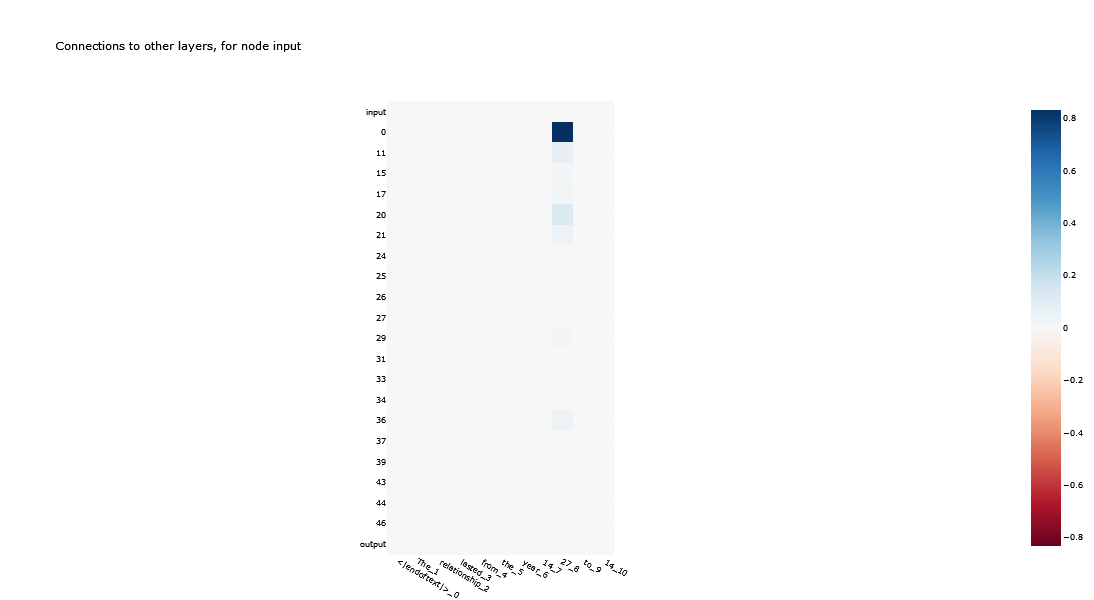

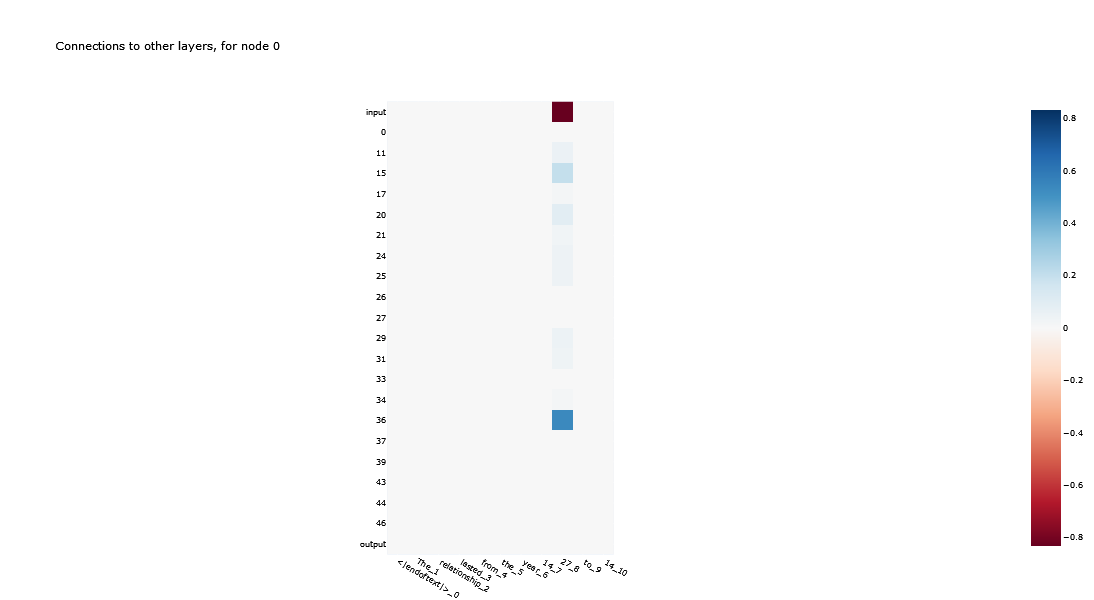

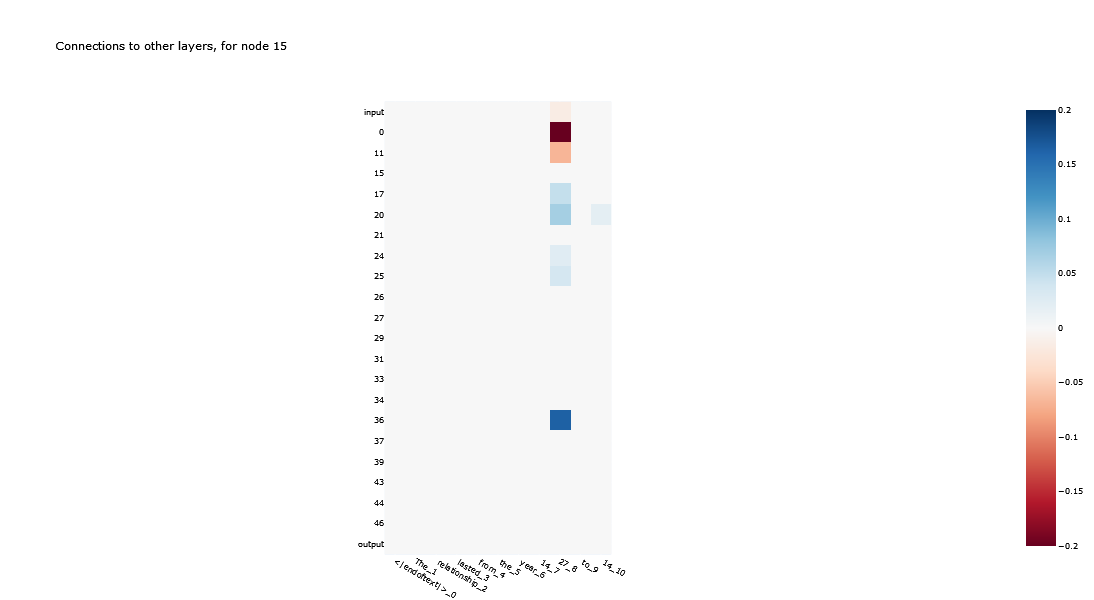

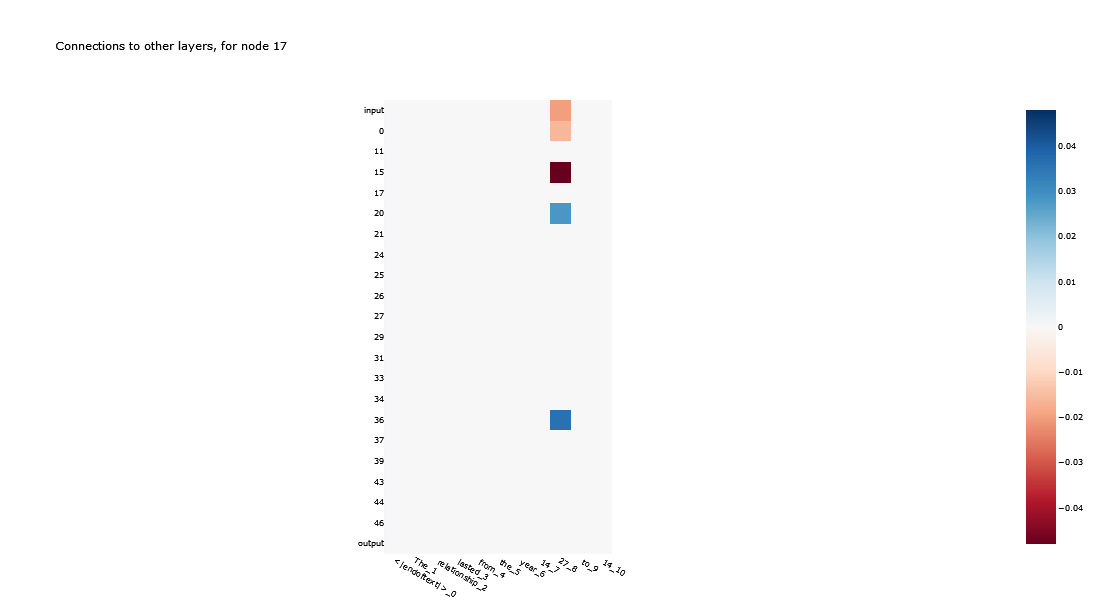

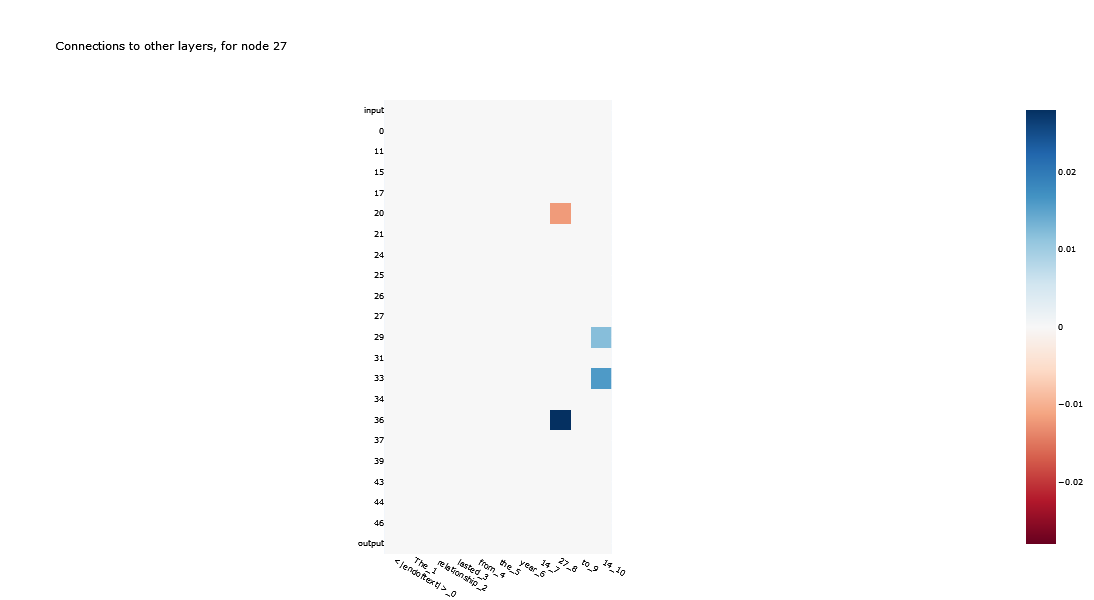

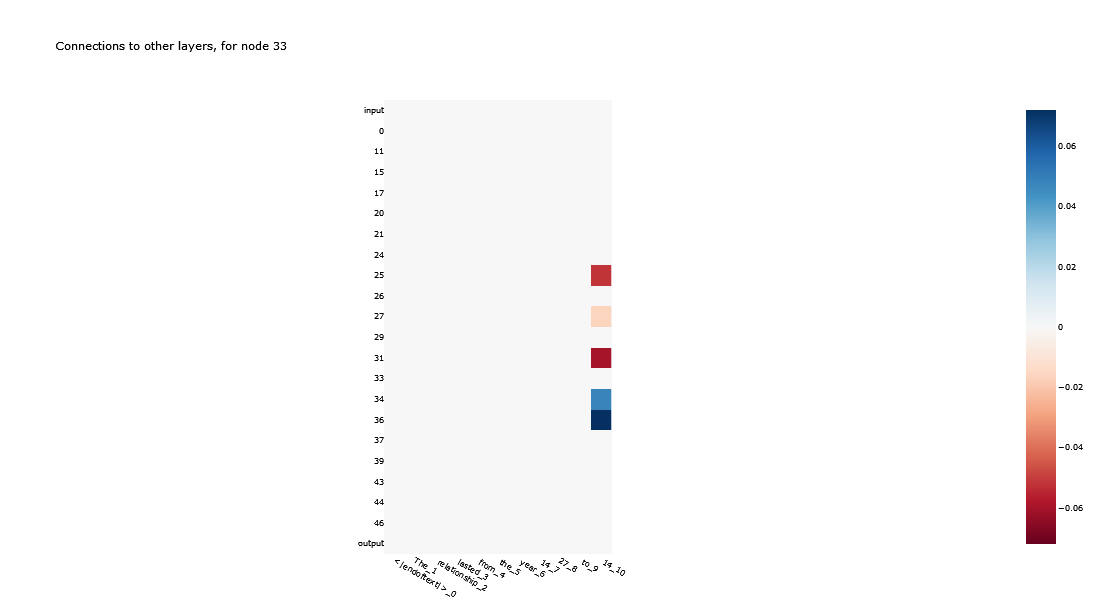

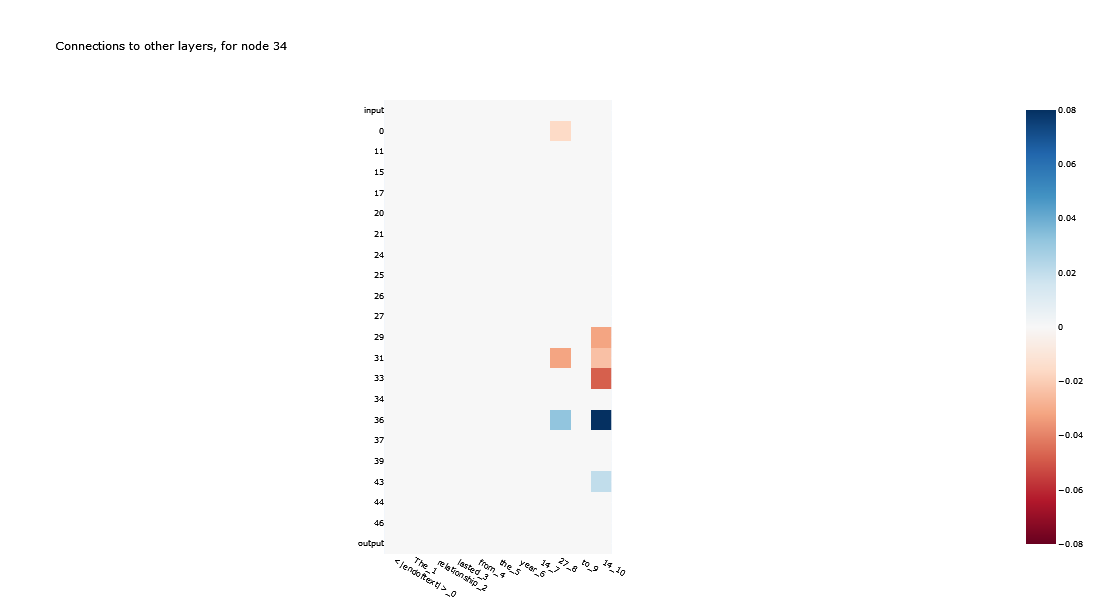

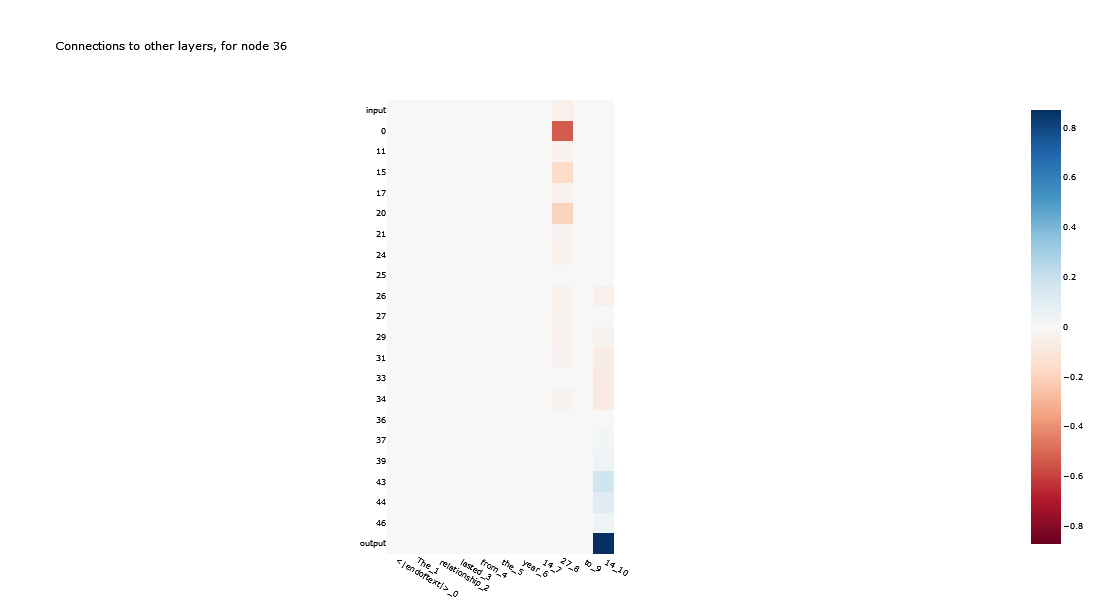

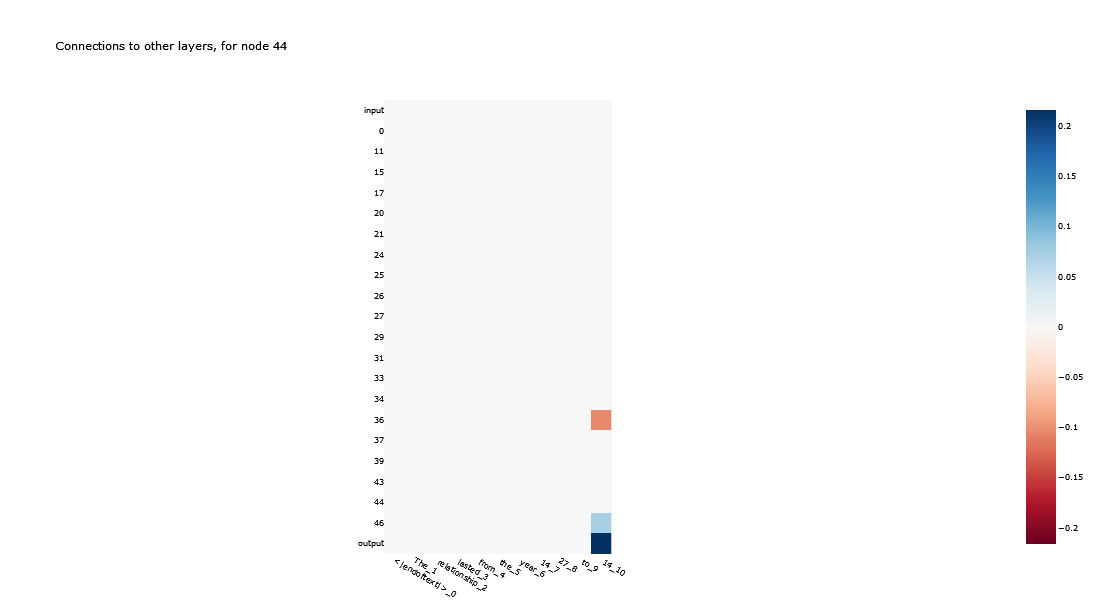

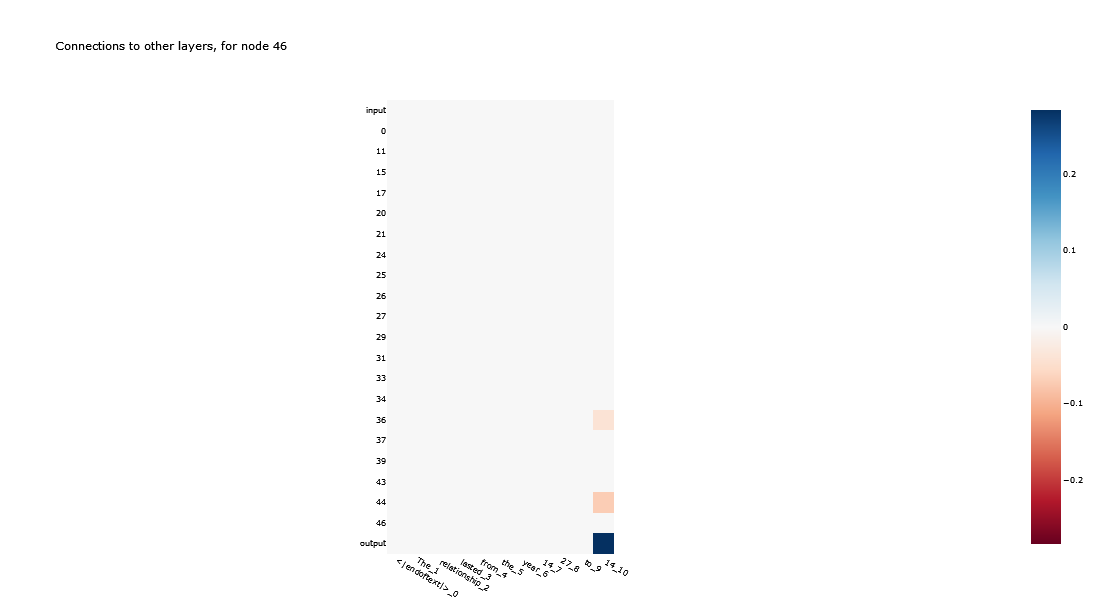

In [84]:
nodes = list(all_nodes.items())

## test for disconnected nodes (ignoring them makes visi less cluttered)
disconnected_nodes = defaultdict(lambda: True)
for edge in edges:
    if not edge.patching:
        disconnected_nodes[edge.input_node] = False
        disconnected_nodes[edge.output_node] = False

ignoring_nodes = []

for node_name, node in nodes:
    if disconnected_nodes[node_name]:
        print(f"{node_name} is disconnected")
        ignoring_nodes.append(node_name)

nodes = [(node_name, node) for (node_name, node) in nodes if not node_name in ignoring_nodes]


# make various mappings that make gathering data easier
layers = [int(node_name) for node_name, node in nodes if not node_name in [INPUT_NODE, OUTPUT_NODE]]
layers.sort()
layer_to_ind = dict([(layer,i+1) for (i,layer) in enumerate(layers)])

def to_index(name):
    if name in [INPUT_NODE, OUTPUT_NODE]:
        return {INPUT_NODE: 0, OUTPUT_NODE: len(nodes)-1}[name]
    else:
        return layer_to_ind[int(name)]

node_name_to_index = dict([(node_name, to_index(node_name)) for node_name, node in nodes])
node_index_to_name = dict([(to_index(node_name), node_name) for node_name, node in nodes])
adjacency_matrix = torch.zeros([len(nodes), len(nodes), L])
num_edges = 0
total_edges = 0
for edge in edges:
    total_edges += 1
    if not edge.patching:
        num_edges += 1
        position = edge.output_hook_params['position']
        adjacency_matrix[node_name_to_index[edge.input_node], node_name_to_index[edge.output_node],position] = edge.score_when_patched
        adjacency_matrix[node_name_to_index[edge.output_node], node_name_to_index[edge.input_node],position] = -edge.score_when_patched

print(f"subgraph has {num_edges} edges out of {total_edges} edges")

ANNOTATION_FONT_SIZE = 7
def add_annotation(fig, annotation):
    for i, line in enumerate(annotation.split("\n")):
        fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                            x=0,
                            y=1.0,
                            showarrow=False,
                            text=line,
                            textangle=0,
                            xanchor='left',
                            yanchor='bottom',
                            xref="paper",
                            yref="paper"))


str_tokens = model.to_str_tokens(batched_data[0])
token_labels = []
for index, token in enumerate(str_tokens):
    token_labels.append(f"{token}_{index}")

labels = [node_index_to_name[i] for i in range(len(nodes))]

print(" ".join(token_labels))
# 10, 25, 
#name_map = {4: 'n1', 6: 'n2', 9: 'n3', 16: 'n4', 18: 'n5'}

'''
labels = [node_index_to_name[i] for i in range(len(nodes))]
print(labels)
for l in range(L):
    fig = imshow(adjacency_matrix[:,:,l], x=labels, y=labels, title=f'Adjacency matrix for IOI circuit, at position {l}', fix_size=True, font_size=8, show=False)
    add_annotation(fig, " ".join(token_labels))
    fig.show()
'''
for i in range(len(nodes)):
    fig = imshow(adjacency_matrix[i,:,:], x=token_labels, y=labels, title=f'Connections to other layers, for node {node_index_to_name[i]}', fix_size=True, font_size=8, show=False)
    #add_annotation(fig, " ".join(token_labels))
    fig.show()

In [ ]:
# todo: get each edge strength (how much it affects accuracy if removed)

# do they decrease in similar amount for train and test set?

# notes:
# 0 takes in all names
# 7 and 17 only look at the n3
# 11 only looks at n4 
# 16 looks at n2,n3,n4,n5 (all except n1)
# 18 looks at 
# 19 takes in name_1, name_3, name_4, name_5


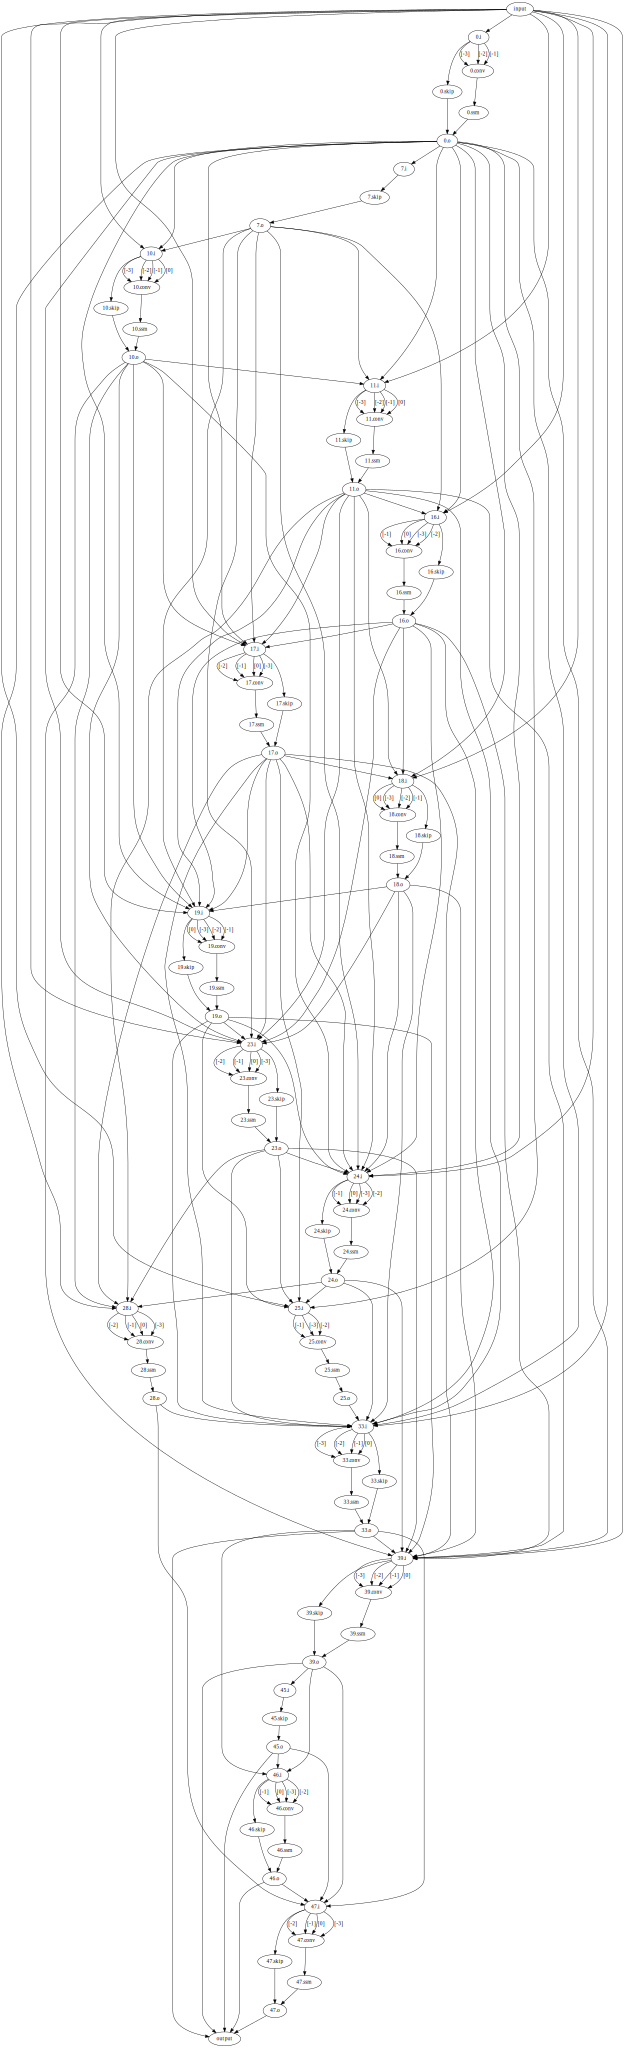

/home/dev/mamba_interp/out_dot.png

In [91]:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

# step 1: do layer pruning
# step 2: do edge based patching to find the edge subset
# step 3: do positional edge based patching

_, edges = load_checkpoint("ioi edges no pos.pkl")
def get_graphviz_graph_modified(edges):
    import graphviz
    dot = graphviz.Digraph('result')
    node_connections = defaultdict(lambda: [])
    for edge in edges:
        if edge.checked and not edge.patching:
            if len(edge.label) > 0:
                node_connections[(edge.input_node, edge.output_node)].append(int(edge.label))
            else:
                dot.edge(edge.input_node, edge.output_node)
    name_map = {4: 'n1', 6: 'n2', 9: 'n3', 16: 'n4', 18: 'n5'}
    #name_map = {8: 'i', 10: 'o'}
    for (input_node, output_node), positions in node_connections.items():
        positions = sorted(list(positions))
        converted_positions = [name_map[int(p)] if int(p) in name_map else str(p) for p in positions]

        dot.edge(input_node, output_node, label=",".join(converted_positions))
    return dot
import tempfile
from PIL import Image
draw_graphviz_graph(cfg=cfg, edges=edges)
import networkx as nx
G = get_graphviz_graph(cfg=cfg, edges=edges)
f_path = "out_dot"
G.render(f_path, format='png') 
from IPython.display import FileLink, display
display(FileLink(f_path + ".png"))

In [100]:
with open("output_edge_positions_final_v5_pruned.pkl", "rb") as f:
    [edges, all_nodes] = cloudpickle.load(f)

## Probing

In [53]:
from sklearn.linear_model import LinearRegression
import numpy as np
# we want to predict the name from the representation
# there are two ways to do this:
# 1. Predict the probability of a rep being a name (output logits for each name)
# 2. Output the name embedding
# we'll start with the second one because it is more general, if that doesn't work we can try the first one


# we're basically doing a tuned lens sorta? idk
# lets start with not batched

# okay so say we are trying to output the name embedding
# on layer i, that could mean:
#    predict emb after it's projected into E space (which is after norm, but before conv)
#    predict emb after conv
#    predict emb after conv and silu
#    predict emb from hidden state or some other internal rep
# the point is that we train this linear map for some specific thing, then how well it performs suggests how well that thing encodes our data,
# so we can try it for lots of intermediate stuff
# some of the maps won't work, that's ok



# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
clean_hooks(model)

# make sure we have no overlap
joined_data = torch.cat([batched_data, vbatched_data, tbatched_data], dim=0)
torch.sort(joined_data, dim=0)
unique = torch.unique(joined_data, dim=0)
torch.manual_seed(27)
# shuffle data
unique = unique[torch.randperm(unique.size()[0])]
B = unique.size()[0]//3
# split into train valid and test
data, vdata, tdata = unique[:B], unique[B:2*B], unique[2*B:3*B]



BATCH_SIZE=3000

B,L = data.size()

# find all token positions that differ in the data (these are the things we want to predict)
positions_that_vary = {}
for i in range(L):
    unique_values = torch.unique(unique[:,i], dim=0)
    if unique_values.size()[0] > 1:
        positions_that_vary[i] = unique_values

# for each position that varies, for each other position, fit a linear model

global probing_dataset_X
probing_dataset_X = []
def dataset_gathering_hook(
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int
):
    global probing_dataset_X
    probing_dataset_X.append(x[:,position,:].cpu())
    return x

output_accuracies = torch.zeros([len(positions_that_vary), model.cfg.n_layers, L])
for position_i, (position, values) in enumerate(positions_that_vary.items()):
    # debug ouptuts
    values = sorted(list(values))
    
    print(f"position {position} has the following values:")
    for tok in values:
        print(f"  tok {tok} {repr(model.tokenizer.decode([tok.item()]))}")

    value_to_class = {}
    for i, tok in enumerate(values):
        value_to_class[tok.item()] = i
        
    # make dataset
    
    def get_linear_classification_X(activations, layer, position_x):
        return activations[f'blocks.{layer}.hook_layer_input'][:,position_x].detach().cpu().numpy()

    def get_linear_classification_Y(input_data, position_y):
        B = input_data.size()[0]
        Y = np.zeros([B,len(values)])
        Y = model.embedding.weight[input_data[:,position_y]]
        return Y.detach().cpu().numpy()
        Y[:] = -1 # predict a vector with -1 for incorrect class and 1 for correct class
        for i in range(B):
            value = input_data[i,position_y].item()
            Y[i,value_to_class[value]] = 1
        return Y
    
    names_filter = [f'blocks.{layer}.hook_layer_input' for layer in range(model.cfg.n_layers)]
    print(data.size())
    logits, activations = model.run_with_cache(data, names_filter=names_filter)
    vlogits, vactivations = model.run_with_cache(vdata, names_filter=names_filter)
    
    Y = get_linear_classification_Y(input_data=data, position_y=position)
    vY = get_linear_classification_Y(input_data=vdata, position_y=position)
    
    for layer in tqdm(list(range(model.cfg.n_layers))):
        for other_position in range(L):
            X = get_linear_classification_X(activations=activations, layer=layer, position_x=other_position)
            linear_model = LinearRegression()
            linear_model.fit(X, Y)
            vX = get_linear_classification_X(activations=vactivations, layer=layer, position_x=other_position)
            pY = linear_model.predict(vX)
            # we want cosine similarity to actual embedding vectors
            avg_sim = cosine_similarity(pY, vY).mean().item()
            #predicted_inds = np.argmax(pY, axis=1)
            #actual_inds = np.argmax(vY, axis=1)
            #acc = np.sum(predicted_inds==actual_inds)/float(predicted_inds.shape[0])
            #print(f"position {position} layer {layer} other position {other_position} acc {acc}")
            output_accuracies[position_i, layer, other_position] = avg_sim

print(f"these token positions vary their value: {positions_that_vary}")




position 2 has the following values:
  tok 789 ' work'
  tok 1055 ' effect'
  tok 1071 ' test'
  tok 1083 ' case'
  tok 1232 ' process'
  tok 1263 ' study'
  tok 1340 ' order'
  tok 1437 ' quest'
  tok 2086 ' program'
  tok 2098 ' plan'
  tok 2199 ' project'
  tok 2332 ' trial'
  tok 2440 ' development'
  tok 2572 ' increase'
  tok 2954 ' relationship'
  tok 2965 ' fall'
  tok 2968 ' deal'
  tok 2983 ' attack'
  tok 3057 ' contact'
  tok 3116 ' growth'
  tok 3310 ' contract'
  tok 3434 ' effort'
  tok 3486 ' impact'
  tok 3946 ' practice'
  tok 4062 ' tradition'
  tok 4086 ' rule'
  tok 4254 ' operation'
  tok 4345 ' agreement'
  tok 4544 ' campaign'
  tok 4679 ' experiments'
  tok 4780 ' progress'
  tok 4892 ' tour'
  tok 4918 ' therapy'
  tok 5008 ' convention'
  tok 5140 ' construction'
  tok 5175 ' testing'
  tok 5216 ' tests'
  tok 5333 ' shift'
  tok 5691 ' challenge'
  tok 5839 ' investigation'
  tok 6054 ' rise'
  tok 6242 ' existence'
  tok 6379 ' decrease'
  tok 6431 ' exchan

  0%|          | 0/48 [00:00<?, ?it/s]

position 7 has the following values:
  tok 1249 ' 12'
  tok 1283 ' 18'
  tok 1458 ' 15'
  tok 1638 ' 14'
  tok 1668 ' 16'
  tok 1722 ' 17'
  tok 2145 ' 13'
torch.Size([402, 11])
torch.Size([402, 1024])
torch.Size([402, 1024])


  0%|          | 0/48 [00:00<?, ?it/s]

position 8 has the following values:
  tok 520 '01'
  tok 746 '19'
  tok 938 '20'
  tok 1093 '18'
  tok 1099 '25'
  tok 1166 '17'
  tok 1229 '30'
  tok 1235 '50'
  tok 1237 '32'
  tok 1348 '24'
  tok 1423 '22'
  tok 1438 '80'
  tok 1449 '40'
  tok 1508 '23'
  tok 1540 '64'
  tok 1549 '60'
  tok 1610 '33'
  tok 1619 '28'
  tok 1630 '27'
  tok 1671 '35'
  tok 1706 '34'
  tok 1717 '29'
  tok 1731 '26'
  tok 1787 '37'
  tok 1797 '21'
  tok 1812 '36'
  tok 1839 '38'
  tok 1857 '45'
  tok 1867 '39'
  tok 1967 '70'
  tok 1976 '75'
  tok 2031 '44'
  tok 2055 '88'
  tok 2082 '65'
  tok 2090 '69'
  tok 2222 '95'
  tok 2227 '85'
  tok 2251 '67'
  tok 2270 '90'
  tok 2357 '77'
  tok 2358 '68'
  tok 2385 '48'
  tok 2405 '31'
  tok 2417 '55'
  tok 2504 '47'
  tok 2511 '89'
  tok 2526 '66'
  tok 2537 '49'
  tok 2597 '87'
  tok 2691 '86'
  tok 2759 '84'
  tok 2787 '79'
  tok 2945 '42'
  tok 2950 '46'
  tok 3011 '57'
  tok 3046 '59'
  tok 3079 '43'
  tok 3121 '76'
  tok 3141 '78'
  tok 3156 '41'
  tok 

  0%|          | 0/48 [00:00<?, ?it/s]

position 10 has the following values:
  tok 1249 ' 12'
  tok 1283 ' 18'
  tok 1458 ' 15'
  tok 1638 ' 14'
  tok 1668 ' 16'
  tok 1722 ' 17'
  tok 2145 ' 13'
torch.Size([402, 11])
torch.Size([402, 1024])
torch.Size([402, 1024])


  0%|          | 0/48 [00:00<?, ?it/s]

these token positions vary their value: {2: tensor([  789,  1055,  1071,  1083,  1232,  1263,  1340,  1437,  2086,  2098,
         2199,  2332,  2440,  2572,  2954,  2965,  2968,  2983,  3057,  3116,
         3310,  3434,  3486,  3946,  4062,  4086,  4254,  4345,  4544,  4679,
         4780,  4892,  4918,  5008,  5140,  5175,  5216,  5333,  5691,  5839,
         6054,  6242,  6379,  6431,  6454,  6803,  7103,  7158,  7324,  7408,
         7466,  7756,  7875,  8410,  8984,  9437,  9455,  9749,  9936, 10343,
        11492, 12027, 13226, 13445, 13555, 14448, 15742, 15850, 17634, 18200,
        18794, 18830, 19429, 19485, 19841, 20142, 20549, 20808, 20818, 21183,
        22080, 22954, 23809, 23848, 23898, 24847, 26018, 27205, 29995, 30859,
        31192, 31233, 31781, 32367, 33758, 34170, 34326, 34526, 36583, 37429,
        38302, 38767, 38886, 38937, 39395, 41013, 43497, 44848, 45540, 45753,
        46626, 47467], device='cuda:0'), 7: tensor([1249, 1283, 1458, 1638, 1668, 1722, 2145], dev

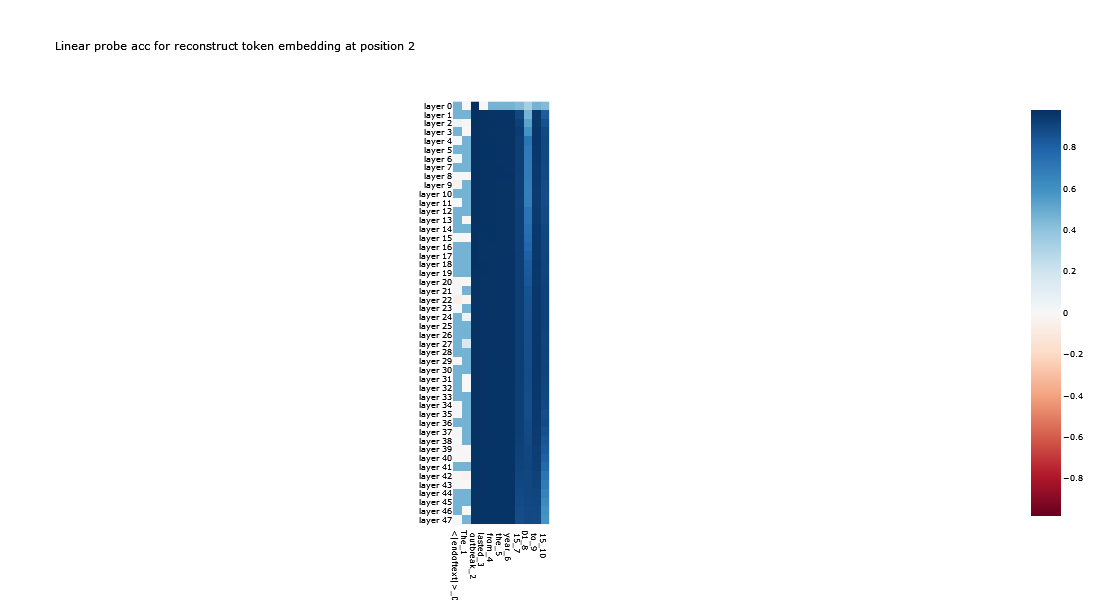

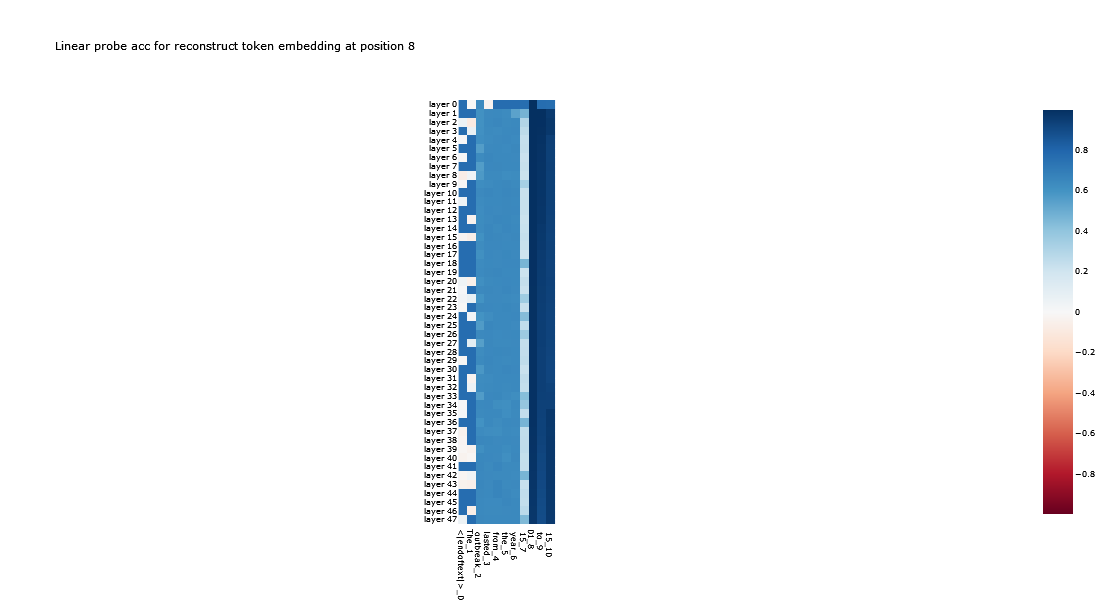

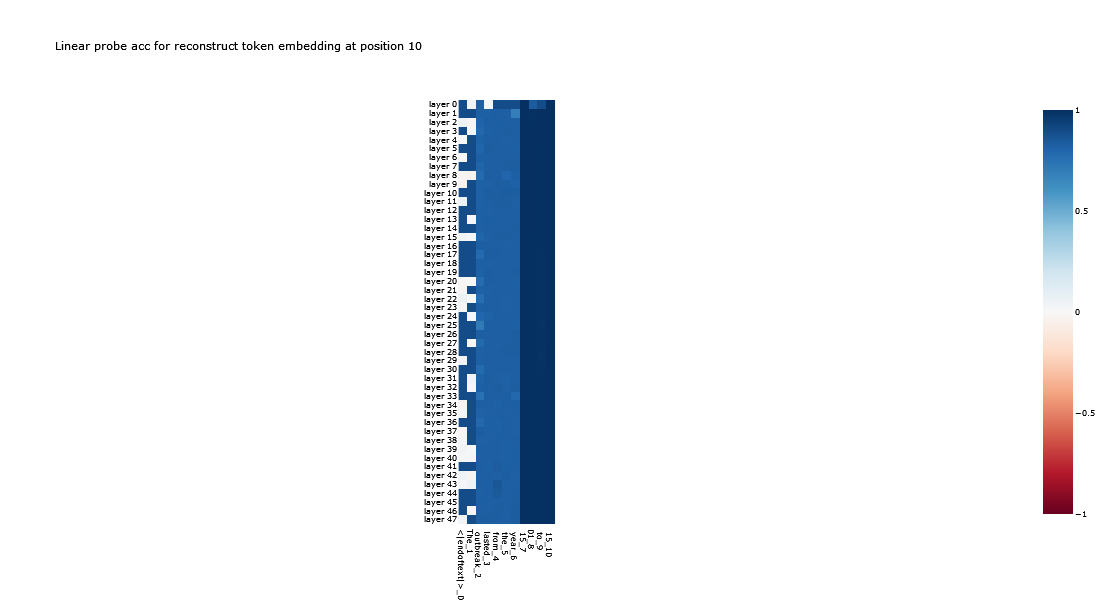

In [54]:

for position_i, (position, values) in enumerate(positions_that_vary.items()):
    # make token labels that describe the patch
    str_tokens = model.to_str_tokens(data[0])
    token_labels = []
    for index, token in enumerate(str_tokens):
        token_labels.append(f"{token}_{index}")
    
    imshow(output_accuracies[position_i], x=token_labels, y=[f'layer {layer}' for layer in range(model.cfg.n_layers)], title=f'Linear probe acc for reconstruct token embedding at position {position}', fix_size=True, font_size=8)

In [96]:
unique.size()

torch.Size([22059, 23])

In [26]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [7]:
print(model.cfg.normalization_type )

LNPre


In [21]:
import copy
BATCH_SIZE = 1000
clean_hooks(model)

# todo: double up things but swapped, so it's symmetric
def patch_layer_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B E N"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, h.size()[0], 2):
        h[i] = h[i+1]
    return h

#limited_layer_set = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]
limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = [0, 11, 13, 17, 18, 19, 20, 23, 24, 25, 26, 29, 30, 31, 33, 34, 35, 36, 37, 39, 41, 43, 44, 45, 46, 47]
#limited_layers = [0, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
B,L = batched_data.size()

def wrap_patch_specific_layers(model, layers_to_patch, **kwargs):
    hooks = []
    for layer in layers_to_patch:
        hooks.append((f"blocks.{layer}.hook_conv", patch_layer_hook))
        for l in range(L):
            hooks.append((f"blocks.{layer}.hook_h.{l}", patch_layer_hook))
    
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    wrapper.cfg = model.cfg
    return wrapper

print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

        
pbatched_data = repeat_swapped_patch(batched_data, has_symmetric_patching=has_symmetric_patching)
pbatched_correct = repeat_swapped_patch(batched_correct, has_symmetric_patching=has_symmetric_patching)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect, has_symmetric_patching=has_symmetric_patching)
vpbatched_data = repeat_swapped_patch(vbatched_data, has_symmetric_patching=has_symmetric_patching)
vpbatched_correct = repeat_swapped_patch(vbatched_correct, has_symmetric_patching=has_symmetric_patching)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect, has_symmetric_patching=has_symmetric_patching)


history = []
history_stats = []
layers_to_patch = []

while len(layers_to_patch) < model.cfg.n_layers:
    remaining_layers = copy.deepcopy(limited_layers)
    for layer in layers_to_patch:
        remaining_layers.remove(layer)
    print("layers not patched", remaining_layers)
    print("layers patched", layers_to_patch)
    correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=layers_to_patch, fast_ssm=False, fast_conv=False,
                                                              only_use_these_layers=limited_layers),
                                    vpbatched_data, vpbatched_correct, vpbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    
    out_acc = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(remaining_layers)], device=model.cfg.device)
        
    for i, start_layer in tqdm(list(enumerate(remaining_layers))):
        #layers = list(range(start_layer, end_layer+1))
        patching_layers = layers_to_patch + [start_layer]
        
        correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=patching_layers, fast_ssm=False, fast_conv=False,
                                                              only_use_these_layers=limited_layers),
                                    pbatched_data, pbatched_correct, pbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc

    print(out_acc)
    best_layer_to_patch = remaining_layers[torch.argsort(-out_acc)[0]]
    print("patching layer", best_layer_to_patch, f"with acc {out_acc[remaining_layers.index(best_layer_to_patch)]}")
    layers_to_patch.append(best_layer_to_patch)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
layers not patched [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched []
correct relative pr 0.887332558631897 incorrect relative pr 0.11266747117042542 accuracy 0.91


  0%|          | 0/17 [00:00<?, ?it/s]

tensor([0.9467, 0.9400, 0.9367, 0.9267, 0.9267, 0.9367, 0.9300, 0.9333, 0.9300,
        0.9267, 0.9233, 0.9233, 0.9433, 0.0067, 0.9367, 0.9233, 0.9067],
       device='cuda:0')
patching layer 0 with acc 0.9466666579246521
layers not patched [7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched [0]
correct relative pr 0.8850835561752319 incorrect relative pr 0.11491648852825165 accuracy 0.9033333333333333


  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0.9533, 0.9500, 0.9300, 0.9200, 0.9367, 0.9300, 0.9267, 0.9300, 0.9267,
        0.9267, 0.9167, 0.9300, 0.0067, 0.9267, 0.9300, 0.9067],
       device='cuda:0')
patching layer 7 with acc 0.95333331823349
layers not patched [10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched [0, 7]
correct relative pr 0.881999135017395 incorrect relative pr 0.11800092458724976 accuracy 0.9


  0%|          | 0/15 [00:00<?, ?it/s]

tensor([0.9400, 0.9500, 0.9233, 0.9467, 0.9333, 0.9367, 0.9367, 0.9333, 0.9300,
        0.9267, 0.9300, 0.0067, 0.9433, 0.9300, 0.9200], device='cuda:0')
patching layer 11 with acc 0.949999988079071
layers not patched [10, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched [0, 7, 11]
correct relative pr 0.8865557312965393 incorrect relative pr 0.11344432830810547 accuracy 0.9033333333333333


  0%|          | 0/14 [00:00<?, ?it/s]

tensor([0.9333, 0.9300, 0.9400, 0.9367, 0.9300, 0.9333, 0.9333, 0.9300, 0.9000,
        0.9267, 0.0067, 0.9500, 0.9467, 0.9133], device='cuda:0')
patching layer 45 with acc 0.949999988079071
layers not patched [10, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 46, 47]
layers patched [0, 7, 11, 45]
correct relative pr 0.9061765670776367 incorrect relative pr 0.09382342547178268 accuracy 0.9166666666666666


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([0.9533, 0.9367, 0.9467, 0.9433, 0.9367, 0.9400, 0.9333, 0.9333, 0.9167,
        0.9333, 0.0067, 0.9600, 0.9233], device='cuda:0')
patching layer 46 with acc 0.9599999785423279
layers not patched [10, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 47]
layers patched [0, 7, 11, 45, 46]
correct relative pr 0.8984776139259338 incorrect relative pr 0.10152245312929153 accuracy 0.9133333333333333


  0%|          | 0/12 [00:00<?, ?it/s]

tensor([0.9600, 0.9500, 0.9567, 0.9500, 0.9567, 0.9633, 0.9500, 0.9500, 0.9333,
        0.9567, 0.0067, 0.9500], device='cuda:0')
patching layer 23 with acc 0.9633333086967468
layers not patched [10, 16, 17, 18, 19, 24, 25, 28, 33, 39, 47]
layers patched [0, 7, 11, 45, 46, 23]
correct relative pr 0.899516224861145 incorrect relative pr 0.10048384219408035 accuracy 0.91


  0%|          | 0/11 [00:00<?, ?it/s]

tensor([0.9567, 0.9533, 0.9567, 0.9533, 0.9467, 0.9533, 0.9533, 0.9400, 0.9567,
        0.0067, 0.9567], device='cuda:0')
patching layer 10 with acc 0.9566666483879089
layers not patched [16, 17, 18, 19, 24, 25, 28, 33, 39, 47]
layers patched [0, 7, 11, 45, 46, 23, 10]
correct relative pr 0.8962239623069763 incorrect relative pr 0.10377608239650726 accuracy 0.91


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.9467, 0.9533, 0.9467, 0.9433, 0.9467, 0.9533, 0.9267, 0.9500, 0.0067,
        0.9500], device='cuda:0')
patching layer 25 with acc 0.95333331823349
layers not patched [16, 17, 18, 19, 24, 28, 33, 39, 47]
layers patched [0, 7, 11, 45, 46, 23, 10, 25]
correct relative pr 0.8920631408691406 incorrect relative pr 0.10793692618608475 accuracy 0.9033333333333333


  0%|          | 0/9 [00:00<?, ?it/s]

tensor([0.9367, 0.9367, 0.9433, 0.9367, 0.9333, 0.9100, 0.9467, 0.0100, 0.9400],
       device='cuda:0')
patching layer 33 with acc 0.9466666579246521
layers not patched [16, 17, 18, 19, 24, 28, 39, 47]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33]
correct relative pr 0.8977327942848206 incorrect relative pr 0.10226721316576004 accuracy 0.9066666666666666


  0%|          | 0/8 [00:00<?, ?it/s]

tensor([0.9333, 0.9400, 0.9433, 0.9300, 0.9400, 0.9233, 0.0100, 0.9267],
       device='cuda:0')
patching layer 18 with acc 0.9433333277702332
layers not patched [16, 17, 19, 24, 28, 39, 47]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18]
correct relative pr 0.8918312788009644 incorrect relative pr 0.10816872119903564 accuracy 0.9


  0%|          | 0/7 [00:00<?, ?it/s]

tensor([0.9333, 0.9433, 0.9433, 0.9333, 0.9233, 0.0100, 0.9367],
       device='cuda:0')
patching layer 17 with acc 0.9433333277702332
layers not patched [16, 19, 24, 28, 39, 47]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17]
correct relative pr 0.8921590447425842 incorrect relative pr 0.10784100741147995 accuracy 0.9


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([0.9367, 0.9333, 0.9333, 0.9267, 0.0100, 0.9367], device='cuda:0')
patching layer 47 with acc 0.9366666674613953
layers not patched [16, 19, 24, 28, 39]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47]
correct relative pr 0.886684000492096 incorrect relative pr 0.11331599205732346 accuracy 0.9


  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.9267, 0.9333, 0.9233, 0.8900, 0.0133], device='cuda:0')
patching layer 19 with acc 0.9333333373069763
layers not patched [16, 24, 28, 39]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47, 19]
correct relative pr 0.8717359900474548 incorrect relative pr 0.12826405465602875 accuracy 0.8833333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0.9300, 0.9167, 0.9033, 0.0133], device='cuda:0')
patching layer 16 with acc 0.9300000071525574
layers not patched [24, 28, 39]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47, 19, 16]
correct relative pr 0.8653842210769653 incorrect relative pr 0.13461583852767944 accuracy 0.8866666666666667


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0.9100, 0.9000, 0.0100], device='cuda:0')
patching layer 24 with acc 0.9100000262260437
layers not patched [28, 39]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47, 19, 16, 24]
correct relative pr 0.8569134473800659 incorrect relative pr 0.14308655261993408 accuracy 0.8733333333333333


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0.8833, 0.0100], device='cuda:0')
patching layer 28 with acc 0.8833333253860474
layers not patched [39]
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47, 19, 16, 24, 28]
correct relative pr 0.8452524542808533 incorrect relative pr 0.15474757552146912 accuracy 0.8666666666666667


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.0133], device='cuda:0')
patching layer 39 with acc 0.013333333656191826
layers not patched []
layers patched [0, 7, 11, 45, 46, 23, 10, 25, 33, 18, 17, 47, 19, 16, 24, 28, 39]
correct relative pr 0.024602780118584633 incorrect relative pr 0.9753972887992859 accuracy 0.02


0it [00:00, ?it/s]

tensor([], device='cuda:0')


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [109]:
model.blocks[0].W_B.bias

tensor(True, device='cuda:0')